# Preparing data

In [ ]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from root_pandas import read_root
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 10.0, 8.0

file_piled = "Piled_2.root"
file_flat = "Flat.root"
file_alpha = "Alpha_11.root"
file_ls = "LS.root"
file_ls_beta = "LS_BETA.root"
file_ref = "RefPulse009.root"

file_pre_analysis = "Run009-230-001.root"

data = "PMTALL"
tree = "tree"

pmt_all_length = 4480

def NORM(file, tree, data):
    pmtall = read_root(file, tree, columns=[data],flatten=[data])
    num_entries, w = pmtall.shape
    num_entries = int(num_entries/pmt_all_length)
    x = pmtall.PMTALL.values.reshape(num_entries, pmt_all_length)
    x_abs = abs(x - 15200)
    extra = np.arange(4096, pmt_all_length)
    x_mod = np.delete(x_abs, extra, axis=1)
    x_nor = normalize(x_mod, norm="l1")
    return x_nor

PMTALL_piled = NORM(file_piled, tree, data)
PMTALL_flat = NORM(file_flat, tree, data)
PMTALL_alpha = NORM(file_alpha, tree, data)
PMTALL_ls = NORM(file_ls, tree, data)
PMTALL_ls_beta = NORM(file_ls_beta, tree, data)
PMTALL_ref = NORM(file_ref, tree, data)

# PMTALL_pre_analysis = NORM(file_pre_analysis, tree, data)
# Standard = np.average(PMTALL_ref,axis=0)

def differ(x,y):
    for i in range(len(x)):
        x[i] = x[i] - y
    return x

# alpha_2 = differ(PMTALL_alpha, Standard)
# ref_2 = differ(PMTALL_ref, Standard)
# pre_2 = differ(PMTALL_pre_analysis, Standard)
# pre_2 = np.expand_dims(pre_2,axis=2)

print("Number of entries")
print("PMTALL_piled :",len(PMTALL_piled))
print("PMTALL_flat :",len(PMTALL_flat))
print("PMTALL_alpha :",len(PMTALL_alpha))
print("PMTALL_ls :",len(PMTALL_ls))
print("PMTALL_ls_beta :",len(PMTALL_ls_beta))
print("PMTALL_ref :",len(PMTALL_ref))
# print("PreAnalysis for testing, number of entries :", len(PMTALL_pre_analysis))


def sep(x, ratio, group):
    train = np.zeros((int(len(x)*ratio), len(x[0])))
    test = np.zeros((int(len(x)*(1-ratio)), len(x[0])))
    for i in range(len(x)):
        if i < int(len(x)*ratio):
            train[i] = x[i]
        if i >= int(len(x)*ratio):
            k = i - int(len(x)*ratio) - 1
            test[k] = x[i]
    train_label = np.zeros(len(train))
    test_label = np.zeros(len(test))
    for i in range(len(train)):
        train_label[i] = group
    for i in range(len(test)):
        test_label[i] = group
    return train, test, train_label, test_label

ratio = 0.8
alpha = sep(PMTALL_alpha, ratio, 0)
ref = sep(PMTALL_ref, ratio, 1)
piled = sep(PMTALL_piled, ratio, 2)
flat = sep(PMTALL_flat, ratio, 3)
ls = sep(PMTALL_ls, ratio, 4)
ls_beta = sep(PMTALL_ls_beta, ratio, 5)

# Alpha_2 = sep(alpha_2, ratio, 0)
# Ref_2 =sep(ref_2, ratio, 1)

del PMTALL_piled, PMTALL_flat, PMTALL_alpha, PMTALL_ls, PMTALL_ls_beta, PMTALL_ref

import keras
def data_for_cnn(x1, x2, x3, x4, x5, x6,z):
    x11, x12, x13, x14 = x1
    x21, x22, x23, x24 = x2
    x31, x32, x33, x34 = x3
    x41, x42, x43, x44 = x4
    x51, x52, x53, x54 = x5
    x61, x62, x63, x64 = x6
    y1 = np.concatenate((x11, x21, x31, x41, x51, x61), axis=0)
    y2 = np.concatenate((x12, x22, x32, x42, x52, x62), axis=0)
    y3 = np.concatenate((x13, x23, x33, x43, x53, x63), axis=0)
    y4 = np.concatenate((x14, x24, x34, x44, x54, x64), axis=0)
    iy1 = np.expand_dims(y1, axis=2)
    iy2 = np.expand_dims(y2, axis=2)
    iy1 = iy1
    iy2 = iy2
    iy3 = keras.utils.to_categorical(y3, z)
    iy4 = keras.utils.to_categorical(y4, z)
    return iy1, iy2, iy3, iy4

classes = 6
train_data, test_data, train_label, test_label = data_for_cnn(piled, flat, alpha, ls, ls_beta, ref,classes)

del piled, flat, alpha, ls, ls_beta, ref

print("done!")

Welcome to JupyROOT 6.10/02


# 4096 input channels? 2^12

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 4093, 16)          80        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 2046, 16)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2043, 32)          2080      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 510, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 503, 64)           16448     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3968)              0         
__________

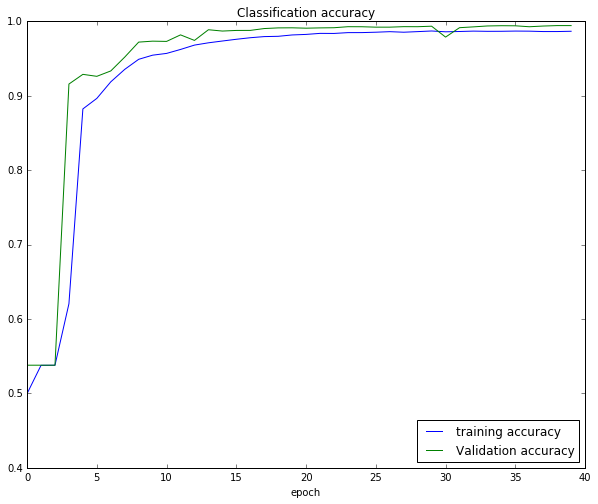

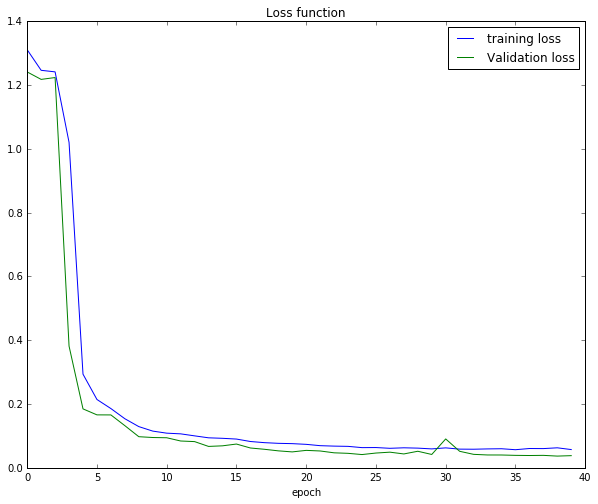

Classification accuracy = 0.994368066984
CPU times: user 12h 34min 44s, sys: 46min 34s, total: 13h 21min 18s
Wall time: 2h 13min 6s


In [4]:
%%time
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization, Embedding, LSTM

from keras.regularizers import l2
from keras.optimizers import SGD

model = Sequential()
model.add(Conv1D(16, kernel_size=4, activation="relu", input_shape=(len(train_data[0]),1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 4, activation="relu"))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(64, 8, activation="relu"))
model.add(MaxPooling1D(pool_size=8))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(8,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(classes,activation="softmax"))
model.summary()
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics=['accuracy'])
history = model.fit(train_data, train_label, batch_size=200, epochs=40, verbose=1, validation_data=(test_data, test_label))
score = model.evaluate(test_data, test_label, verbose=0)
model.save("CNN_1.h5")

print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

# Notes

alpha and ref, this need improvement_works to be done due to previously the technique i studied. for efficient separation I minus a STANDARD pulse shape where the difference between the two can be highlighted more.



41259/41259 [==============================] - 29s 702us/step


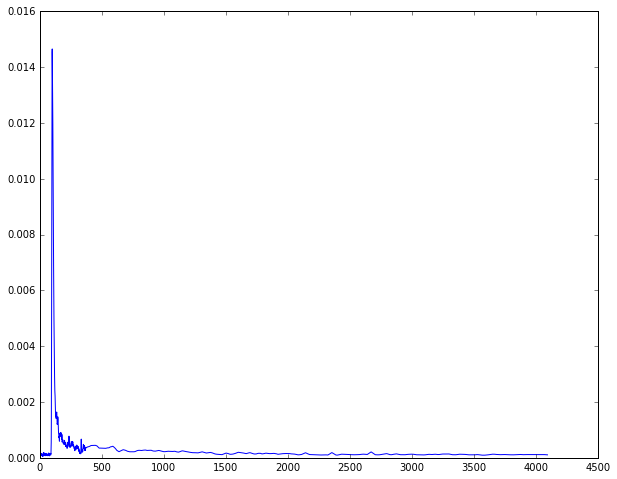

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.23405372e-11   0.00000000e+00   9.52668620e-30   1.00000000e+00
   6.33712953e-34   4.26259946e-14]


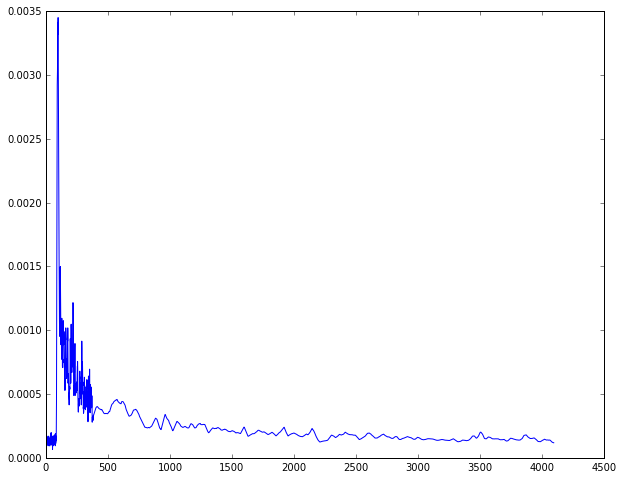

alpha, ref, piled, flast, 
 ls, ls+beta
[  4.53956418e-05   7.10570535e-12   8.05089826e-08   2.76916808e-06
   3.47505562e-07   9.99951363e-01]


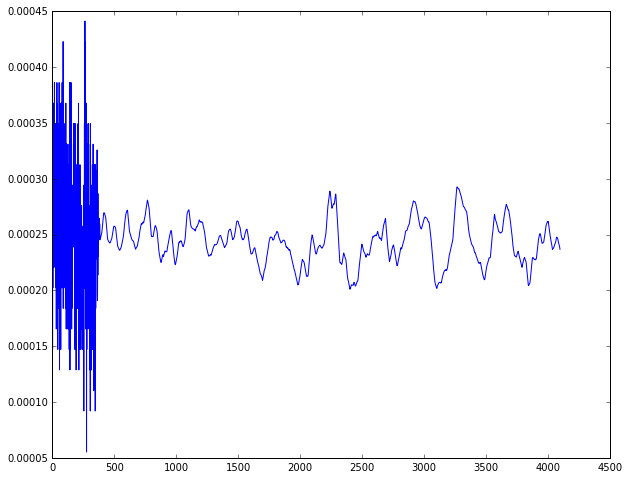

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.55142576e-23   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   8.97147701e-29]


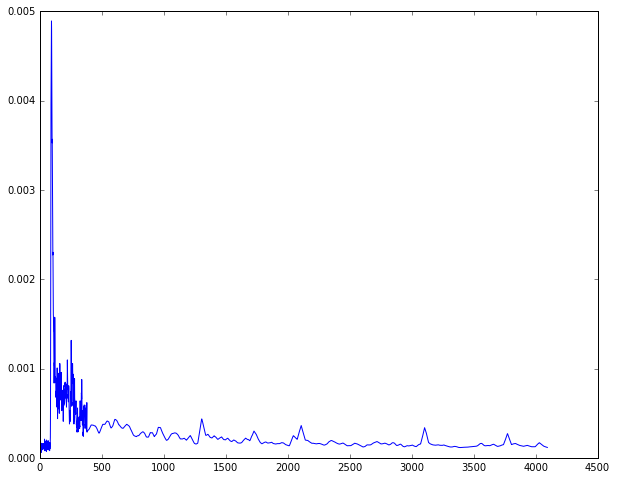

alpha, ref, piled, flast, 
 ls, ls+beta
[  9.40844999e-04   6.60863497e-09   5.24478719e-06   1.44049933e-04
   4.33628338e-06   9.98905540e-01]


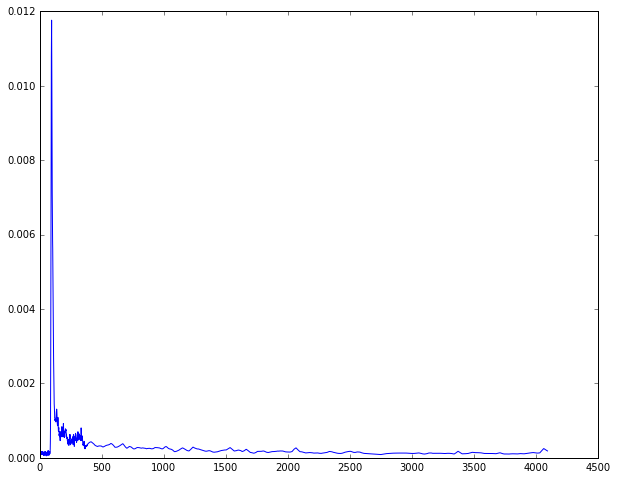

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.00417201e-05   1.39978928e-27   3.85276059e-16   9.99989748e-01
   5.21873573e-19   2.13182119e-07]


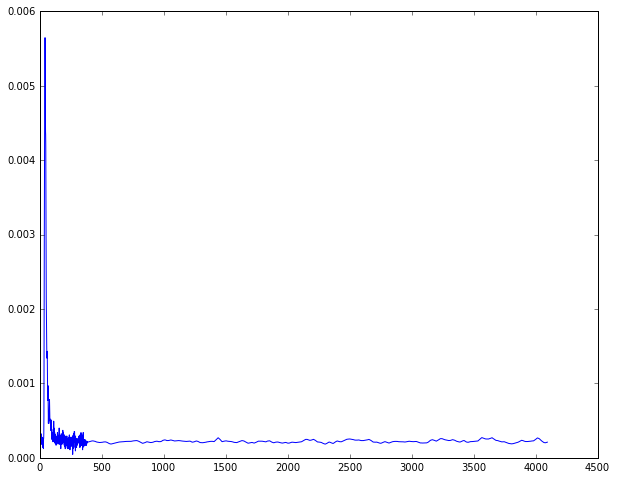

alpha, ref, piled, flast, 
 ls, ls+beta
[  0.00000000e+00   0.00000000e+00   2.15629029e-06   0.00000000e+00
   9.99997854e-01   1.51684333e-30]


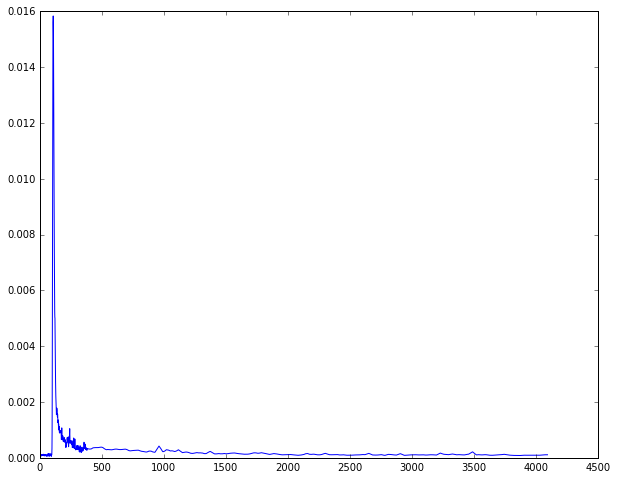

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.14525511e-12   0.00000000e+00   2.38390966e-34   1.00000000e+00
   0.00000000e+00   8.29557440e-16]


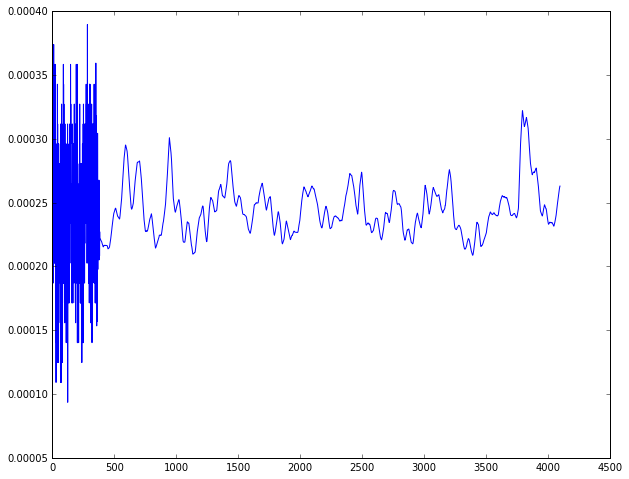

alpha, ref, piled, flast, 
 ls, ls+beta
[  6.36747092e-18   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   1.79782779e-21]


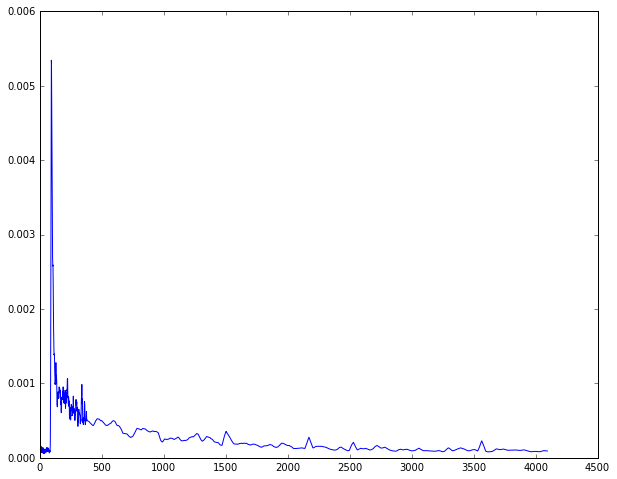

alpha, ref, piled, flast, 
 ls, ls+beta
[  2.01652860e-04   2.77478984e-10   7.83515361e-07   1.73562385e-05
   1.70725514e-06   9.99778569e-01]


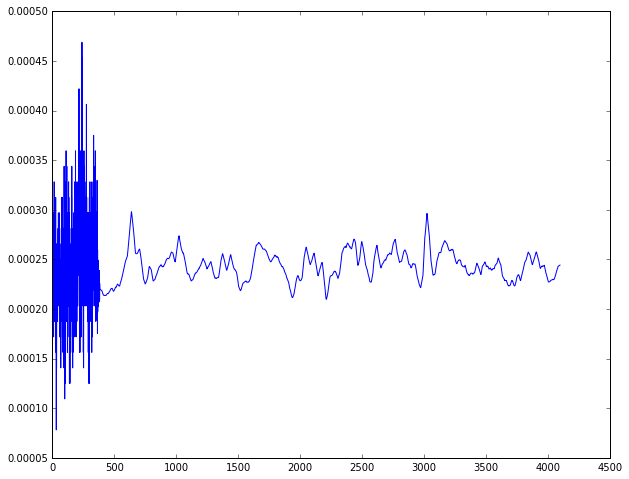

alpha, ref, piled, flast, 
 ls, ls+beta
[  3.43850841e-17   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   1.61414732e-20]


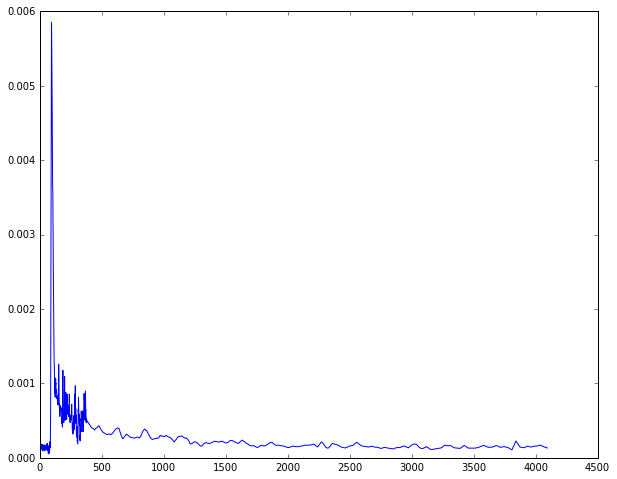

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.13927716e-04   1.92252429e-11   1.57902036e-07   1.52697085e-05
   2.12300762e-07   9.99870420e-01]


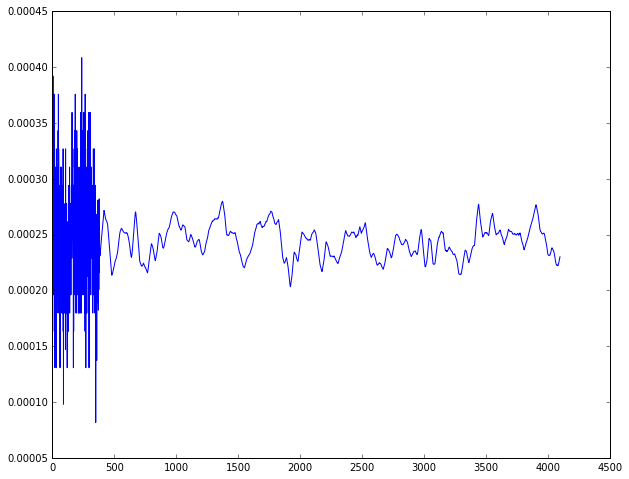

alpha, ref, piled, flast, 
 ls, ls+beta
[  2.69848368e-17   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   1.12115374e-20]


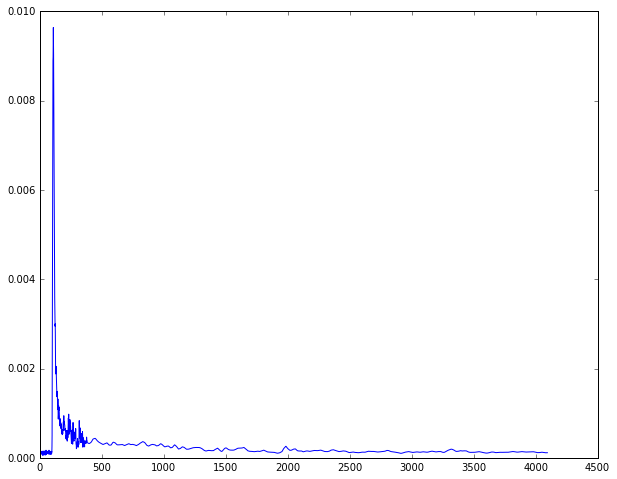

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.21102367e-05   3.99961156e-24   2.31830885e-14   9.98930514e-01
   2.15927598e-16   9.87306121e-04]


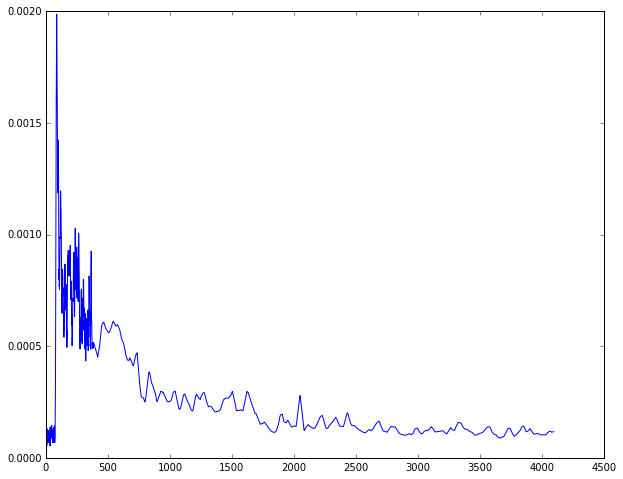

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.78611939e-04   3.10896309e-10   6.85582393e-07   1.11804529e-05
   2.41913972e-06   9.99807179e-01]


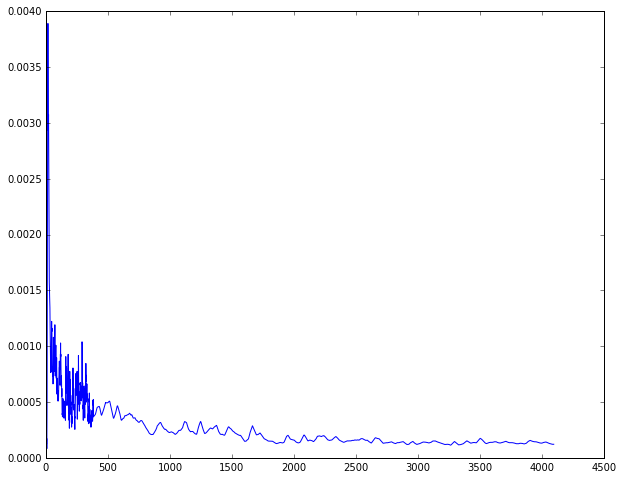

alpha, ref, piled, flast, 
 ls, ls+beta
[ 0.  0.  0.  1.  0.  0.]


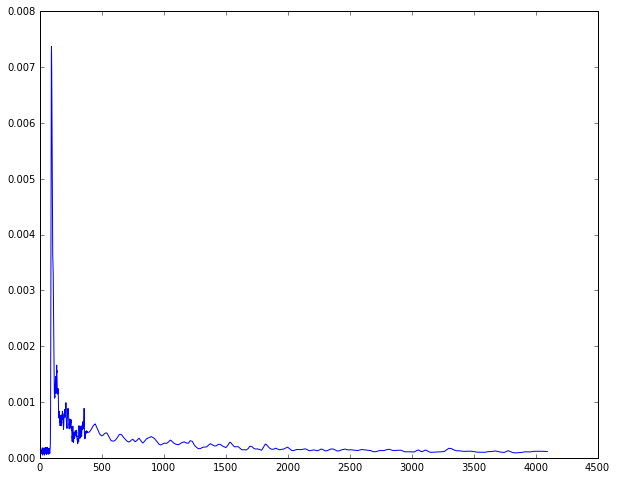

alpha, ref, piled, flast, 
 ls, ls+beta
[  6.63151266e-03   5.32887123e-10   3.12926045e-06   1.11557655e-02
   2.89743269e-07   9.82209325e-01]


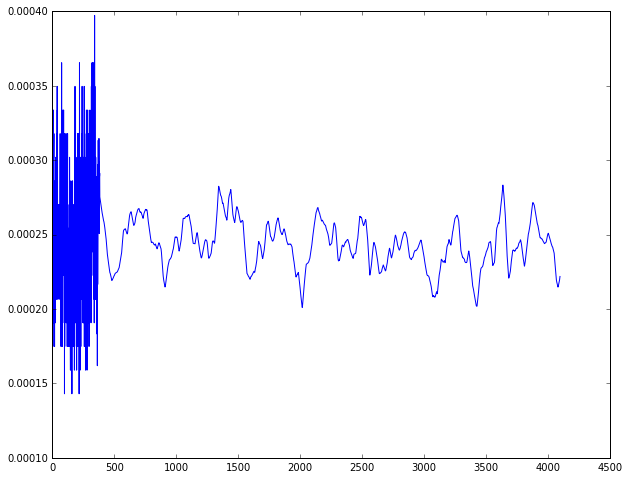

alpha, ref, piled, flast, 
 ls, ls+beta
[  5.65552497e-20   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   2.90457540e-24]


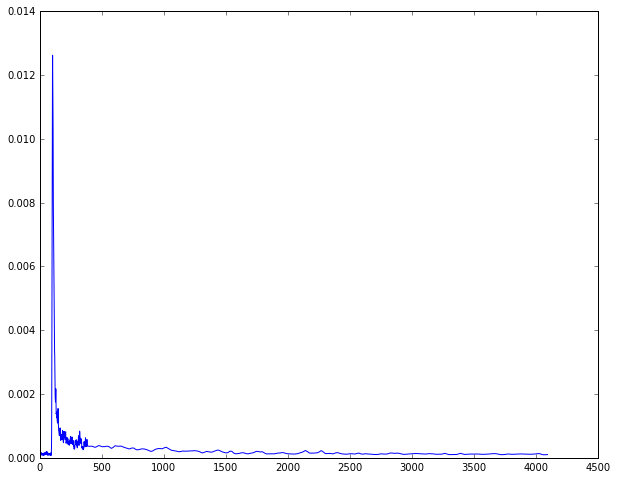

alpha, ref, piled, flast, 
 ls, ls+beta
[  4.16680876e-08   1.96938127e-37   3.78027245e-22   1.00000000e+00
   1.30755692e-25   6.17786711e-10]


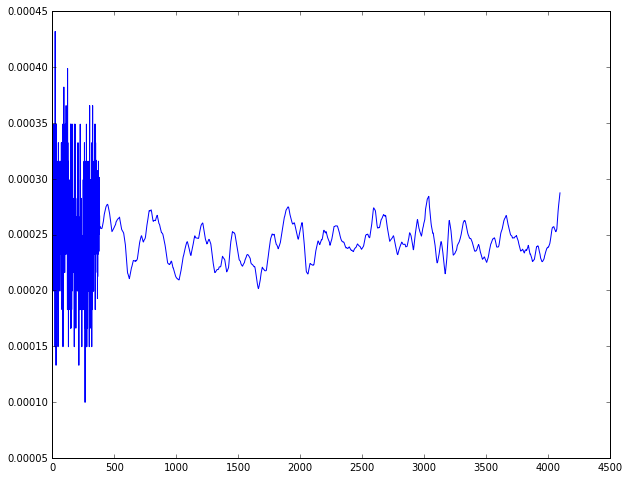

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.21392270e-19   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   9.87829217e-24]


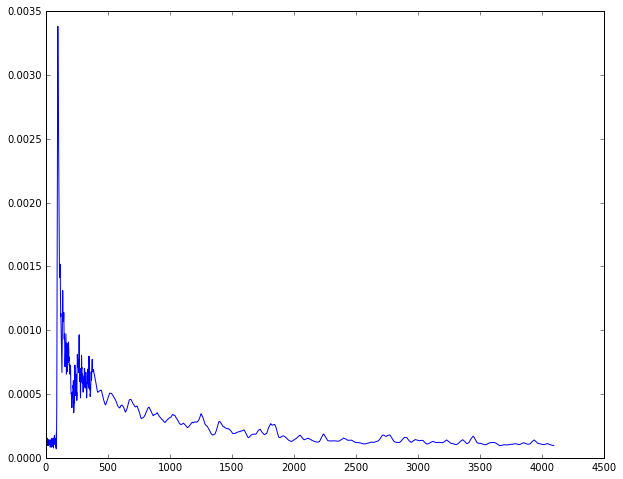

alpha, ref, piled, flast, 
 ls, ls+beta
[  5.37972010e-05   1.35937858e-11   1.11687513e-07   3.07094706e-06
   5.27581790e-07   9.99942541e-01]


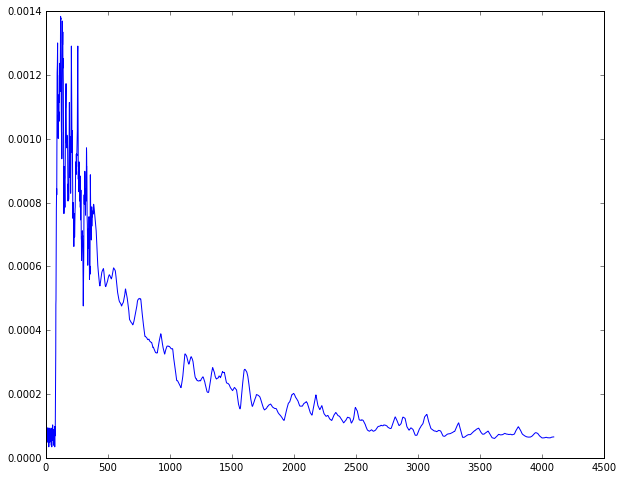

alpha, ref, piled, flast, 
 ls, ls+beta
[  5.16293012e-02   9.06508446e-01   4.03423421e-02   1.35503558e-03
   2.94118081e-07   1.64613986e-04]


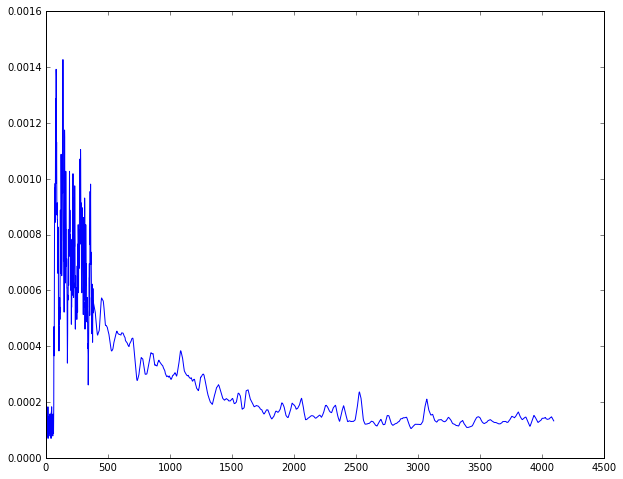

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.75820816e-01   3.03701556e-04   1.28829433e-02   1.04247078e-01
   3.06019888e-06   6.74240384e-03]


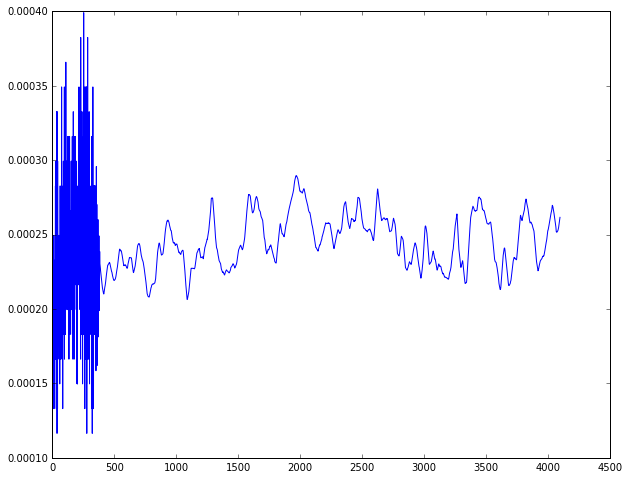

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.84787310e-10   0.00000000e+00   1.62826832e-25   1.00000000e+00
   2.08063027e-28   6.99162006e-10]


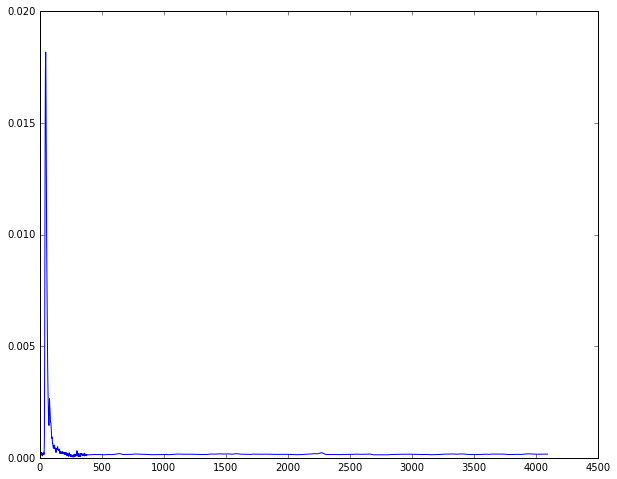

alpha, ref, piled, flast, 
 ls, ls+beta
[  0.00000000e+00   0.00000000e+00   8.48778992e-10   0.00000000e+00
   1.00000000e+00   0.00000000e+00]


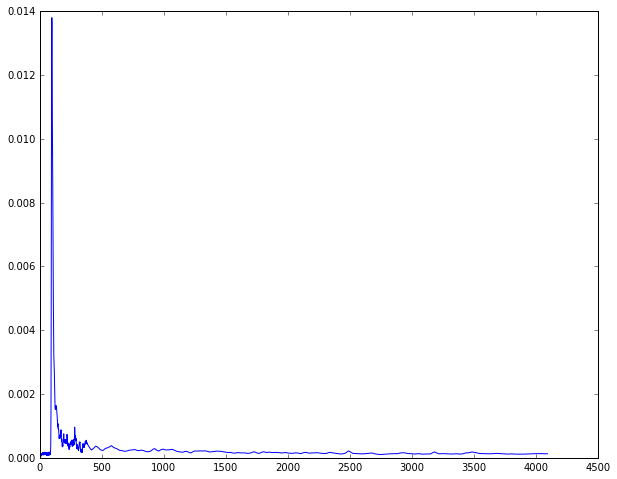

alpha, ref, piled, flast, 
 ls, ls+beta
[  9.56126645e-09   0.00000000e+00   2.46696250e-24   1.00000000e+00
   5.57543045e-28   1.38598941e-11]


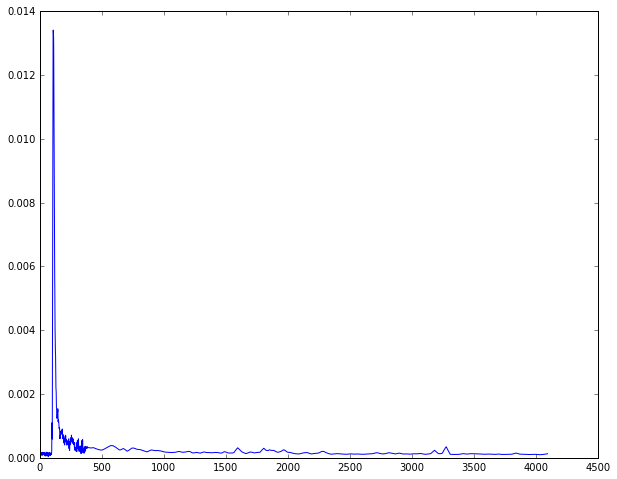

alpha, ref, piled, flast, 
 ls, ls+beta
[  2.42990073e-10   0.00000000e+00   5.35995741e-28   1.00000000e+00
   4.81372460e-32   1.38451436e-12]


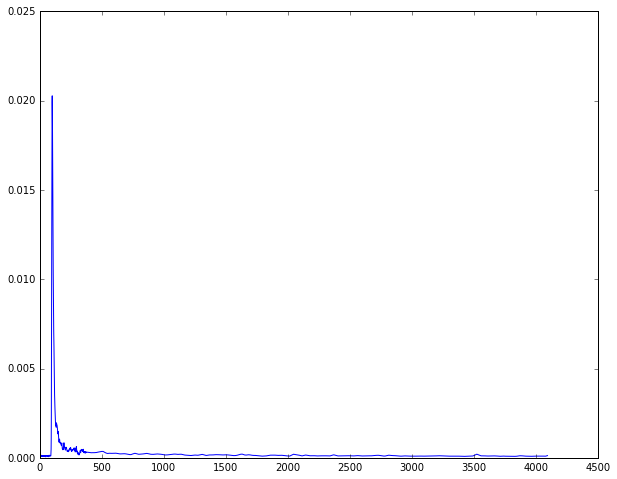

alpha, ref, piled, flast, 
 ls, ls+beta
[  4.04730892e-15   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   4.55873582e-20]


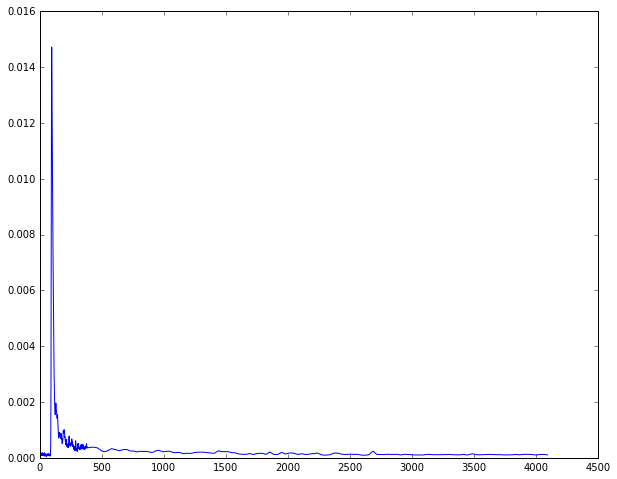

alpha, ref, piled, flast, 
 ls, ls+beta
[  2.35506992e-09   0.00000000e+00   4.05524549e-26   1.00000000e+00
   5.51454869e-30   1.53455937e-12]


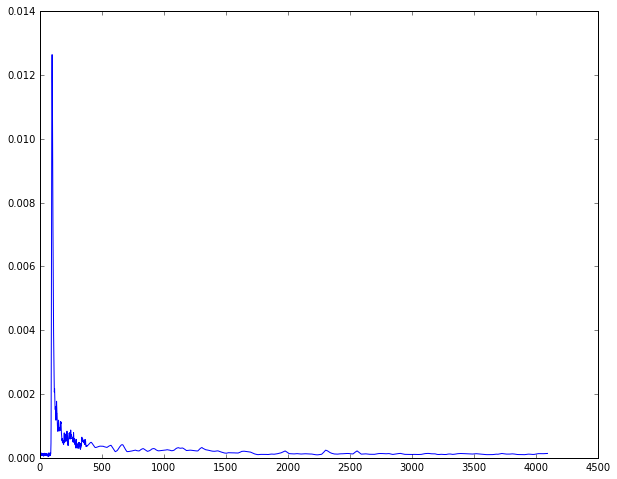

alpha, ref, piled, flast, 
 ls, ls+beta
[  2.51760746e-08   0.00000000e+00   5.63338194e-23   1.00000000e+00
   1.93875602e-26   9.39017752e-11]


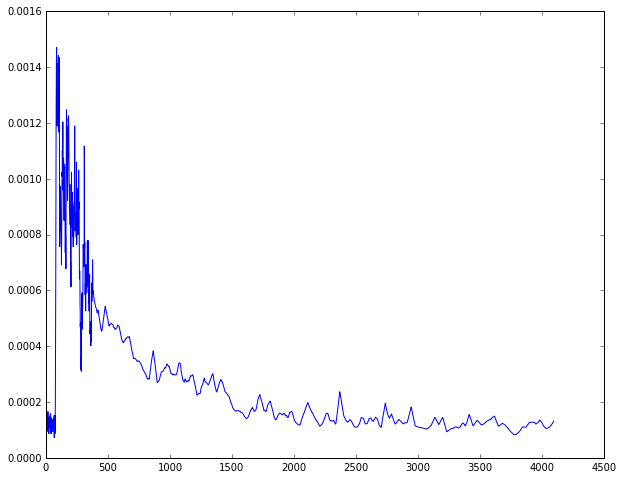

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.39318335e-01   1.75818030e-04   1.02778124e-02   1.38127312e-01
   4.68597727e-06   1.20961517e-02]


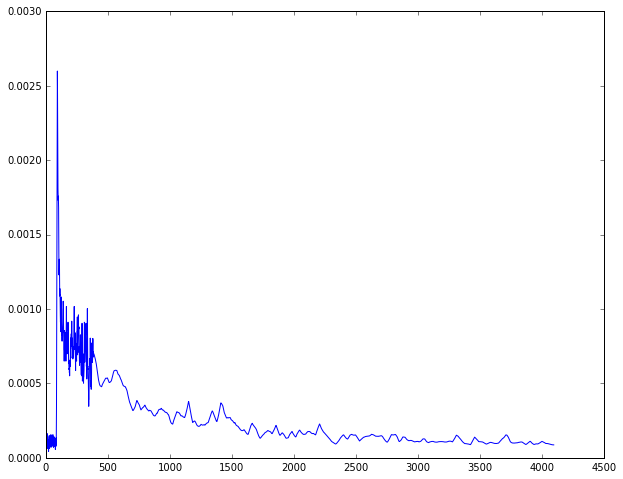

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.64910343e-05   8.45792566e-13   2.29428423e-08   6.88773241e-07
   1.84013786e-07   9.99982595e-01]


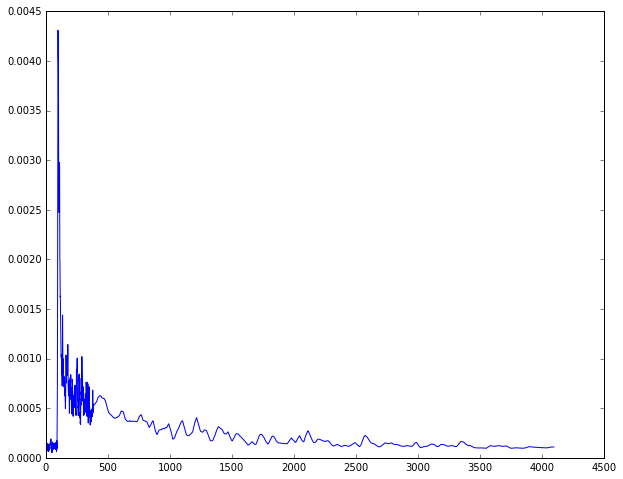

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.85357513e-05   3.78519854e-11   2.11943188e-07   6.23300912e-06
   7.07167601e-07   9.99904275e-01]


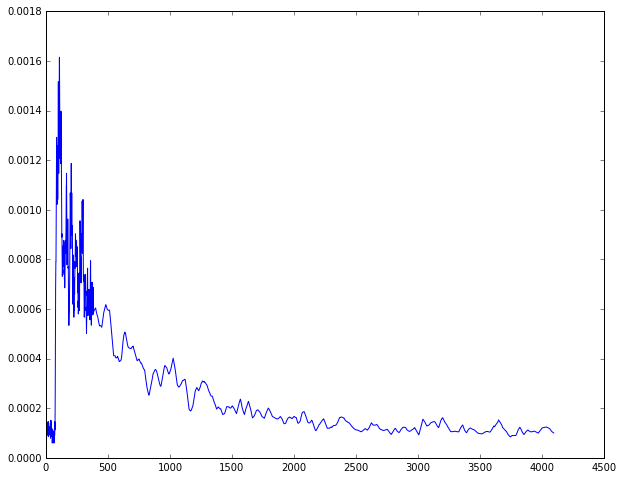

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.66019368e-01   1.21872383e-03   2.34916415e-02   9.83647928e-02
   9.45884585e-06   1.08960867e-02]


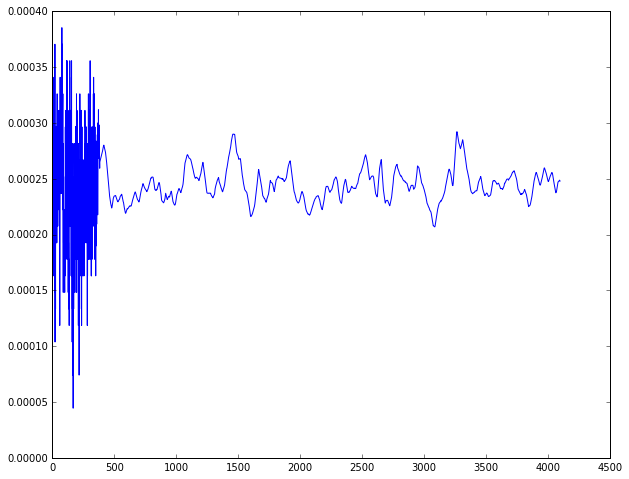

alpha, ref, piled, flast, 
 ls, ls+beta
[  7.26023506e-19   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   9.93627234e-23]


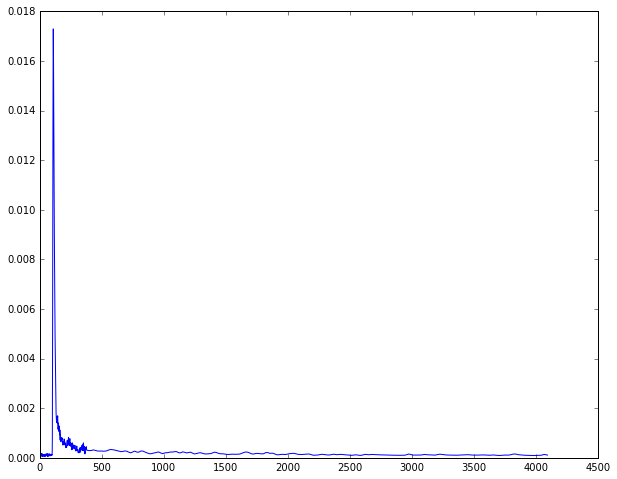

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.82882092e-13   0.00000000e+00   1.52189761e-34   1.00000000e+00
   0.00000000e+00   9.51048699e-16]


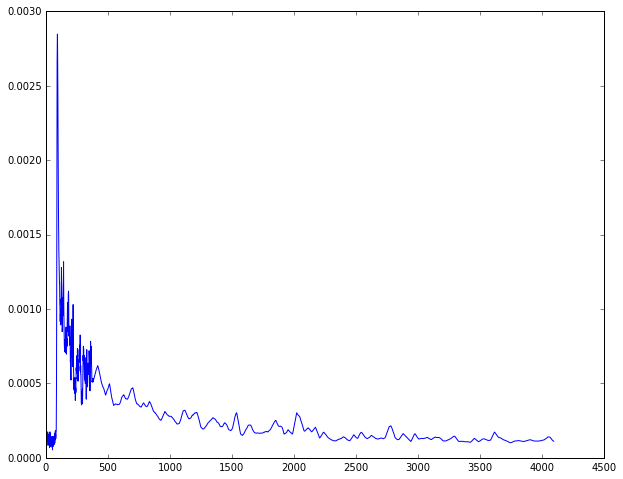

alpha, ref, piled, flast, 
 ls, ls+beta
[  6.71099624e-05   2.08435127e-11   1.41259605e-07   4.19392472e-06
   5.79871710e-07   9.99927998e-01]


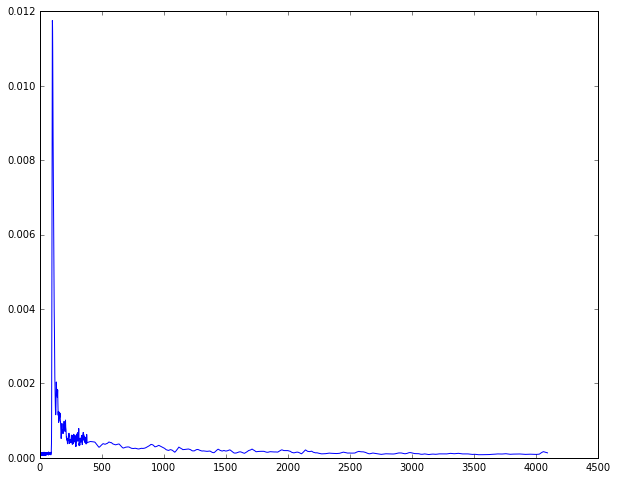

alpha, ref, piled, flast, 
 ls, ls+beta
[  3.98915375e-07   5.97313238e-33   1.61444317e-19   9.99999642e-01
   9.95842861e-23   1.21827588e-08]


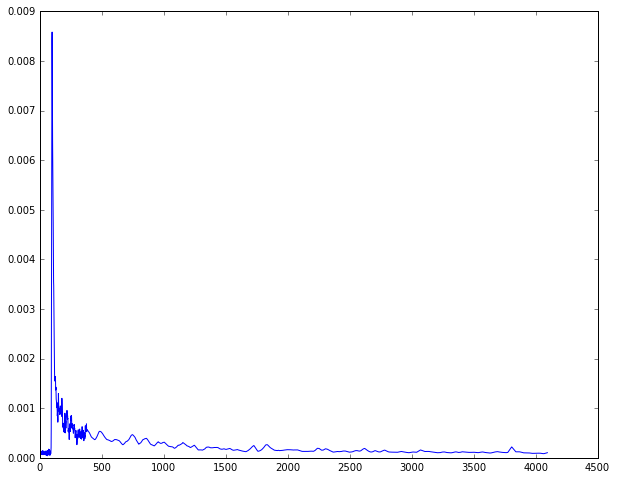

alpha, ref, piled, flast, 
 ls, ls+beta
[  7.27467658e-03   2.49052352e-14   2.20179643e-08   2.34696001e-01
   1.09543241e-09   7.58029342e-01]


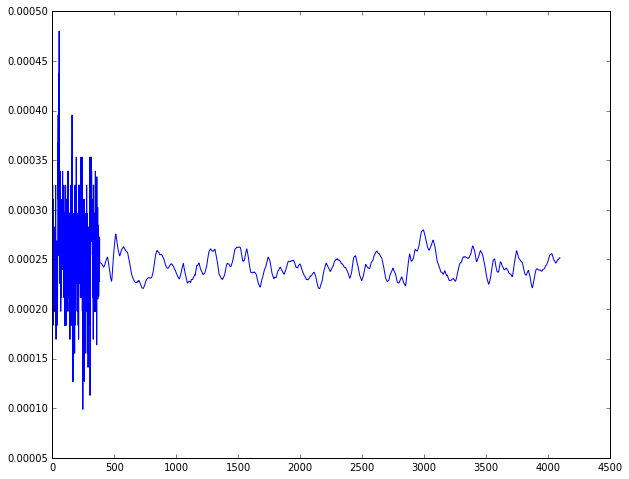

alpha, ref, piled, flast, 
 ls, ls+beta
[  1.46678345e-15   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   1.00423846e-17]


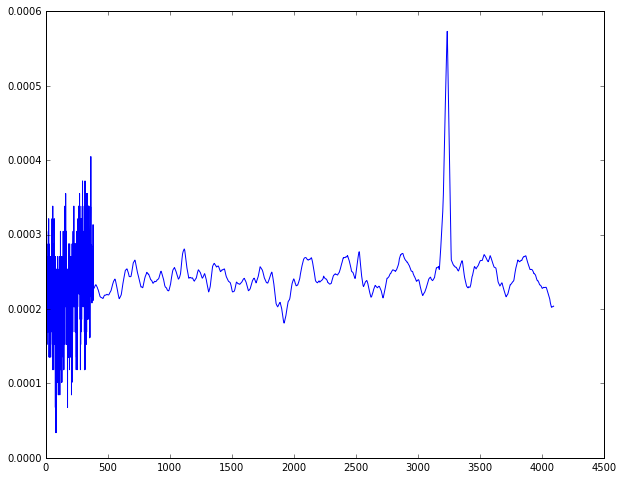

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.30748976e-14   0.00000000e+00   4.79215269e-35   1.00000000e+00
   0.00000000e+00   4.92491468e-15]


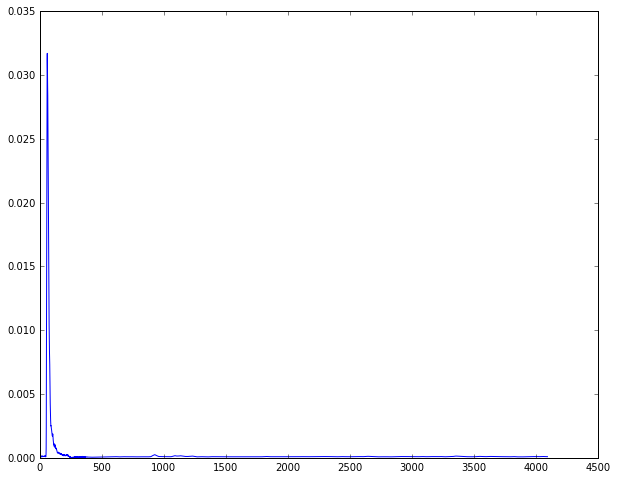

alpha, ref, piled, flast, 
 ls, ls+beta
[  0.00000000e+00   0.00000000e+00   4.63710709e-10   0.00000000e+00
   1.00000000e+00   0.00000000e+00]


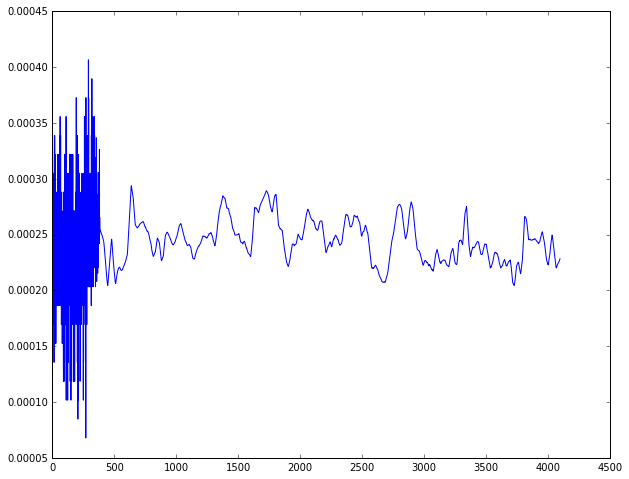

alpha, ref, piled, flast, 
 ls, ls+beta
[  4.76196215e-18   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   1.30783404e-21]


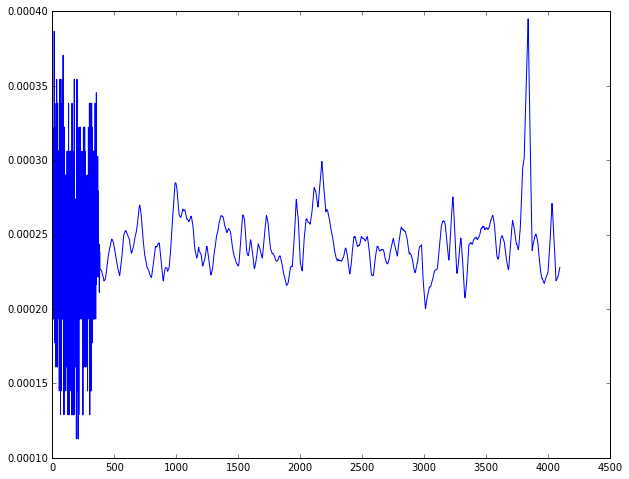

alpha, ref, piled, flast, 
 ls, ls+beta
[  7.33304176e-21   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   2.90842120e-25]


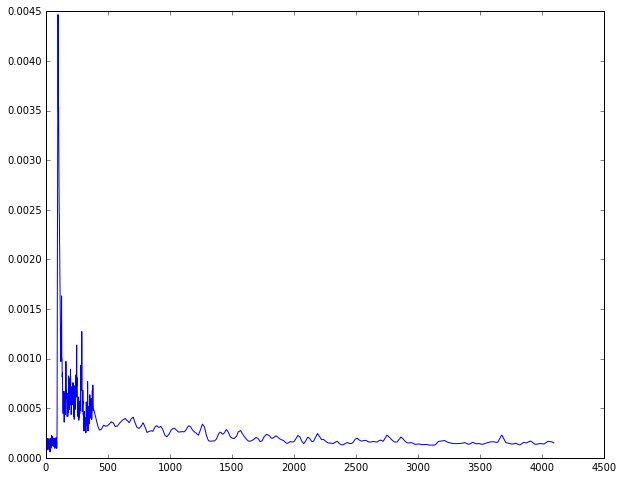

alpha, ref, piled, flast, 
 ls, ls+beta
[  2.09346093e-04   2.07379641e-10   5.76885043e-07   2.10553335e-05
   1.08248912e-06   9.99767959e-01]


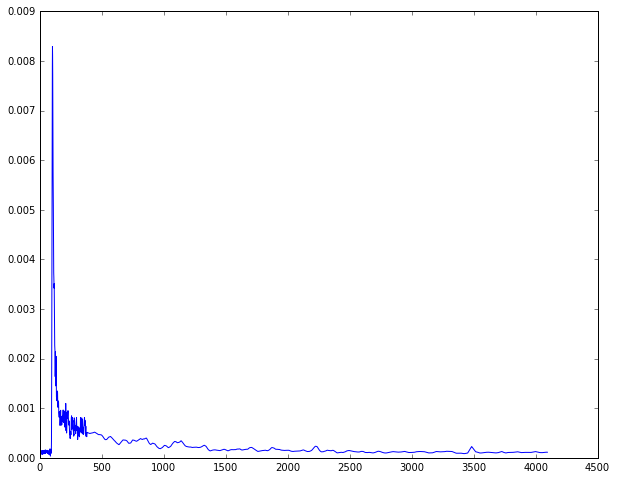

alpha, ref, piled, flast, 
 ls, ls+beta
[  4.76690388e-04   5.23456909e-14   1.09653824e-08   1.95877440e-03
   2.29341990e-09   9.97564554e-01]


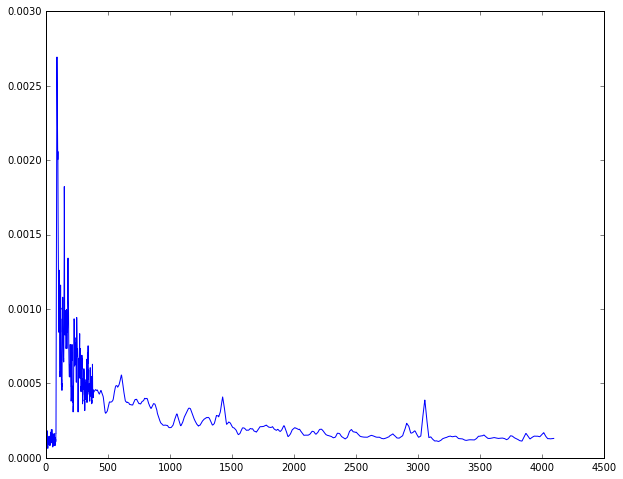

alpha, ref, piled, flast, 
 ls, ls+beta
[  9.27318397e-05   4.82252190e-11   2.31202321e-07   6.01582633e-06
   8.64011213e-07   9.99900222e-01]


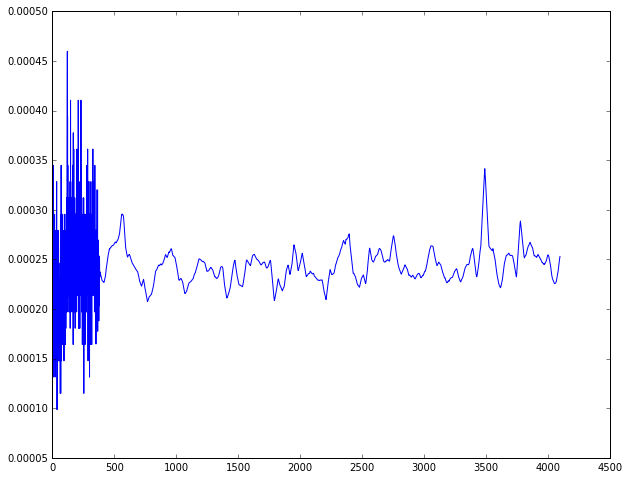

alpha, ref, piled, flast, 
 ls, ls+beta
[  6.12225062e-11   0.00000000e+00   2.44959145e-27   1.00000000e+00
   1.54773175e-30   4.44119325e-11]


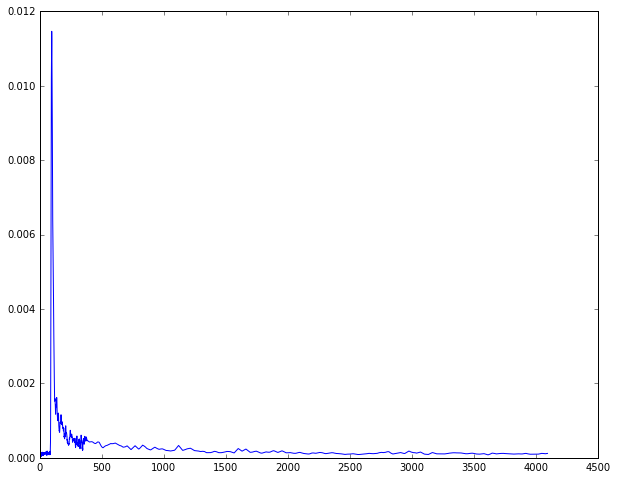

alpha, ref, piled, flast, 
 ls, ls+beta
[  3.84140230e-06   5.86440966e-30   1.99897294e-17   9.99996185e-01
   2.15494734e-20   2.82198087e-08]


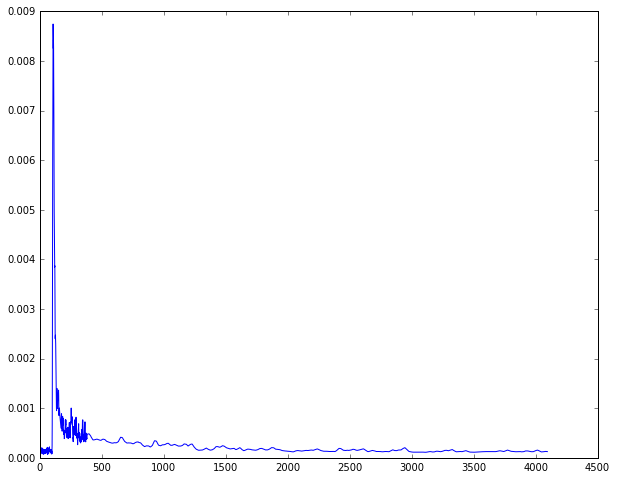

alpha, ref, piled, flast, 
 ls, ls+beta
[  8.59036867e-04   3.33906899e-20   1.07228332e-11   3.66442531e-01
   7.45004535e-13   6.32698417e-01]


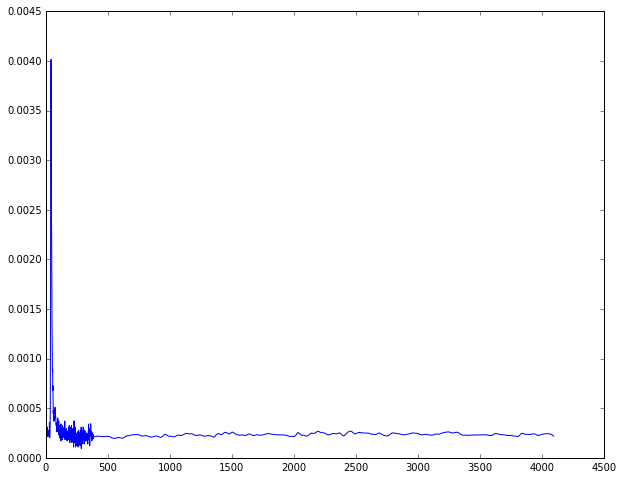

alpha, ref, piled, flast, 
 ls, ls+beta
[  0.00000000e+00   0.00000000e+00   6.23385058e-05   0.00000000e+00
   9.99937654e-01   1.26963682e-21]
CPU times: user 2min 59s, sys: 12.2 s, total: 3min 11s
Wall time: 47.6 s


In [5]:
%%time

from keras.models import load_model
model = load_model("CNN_1.h5")

PMTALL_pre_analysis = NORM(file_pre_analysis, tree, data)
PMTALL_pre_analysis = np.expand_dims(PMTALL_pre_analysis,axis=2)

pred = model.predict(PMTALL_pre_analysis,batch_size=50,verbose=1)
x = np.arange(0,len(PMTALL_pre_analysis[1]),1)

for i in range(50):
    k = np.random.randint(len(PMTALL_pre_analysis))
    plt.figure()
    plt.plot(x,PMTALL_pre_analysis[k])
    plt.show()
    print("alpha, ref, piled, flast, \n ls, ls+beta")
    print(pred[k])
    
del PMTALL_pre_analysis

# a second network is required!

for good separation between two similarly shaped waveform. from earlier studies, We found out that for effective separation of alpha and gamma events, we need a secondary network where the input is modified by subtracting a standard waveform, ie. an averaged reference pulse.



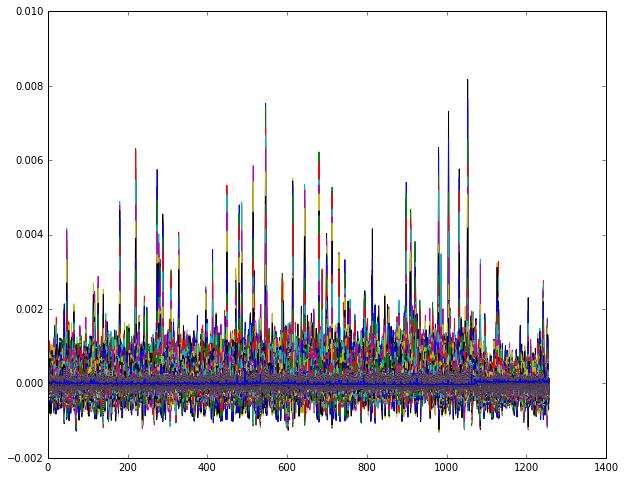

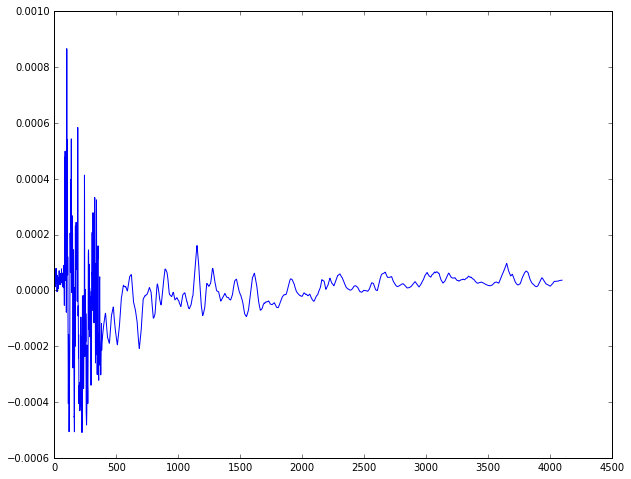

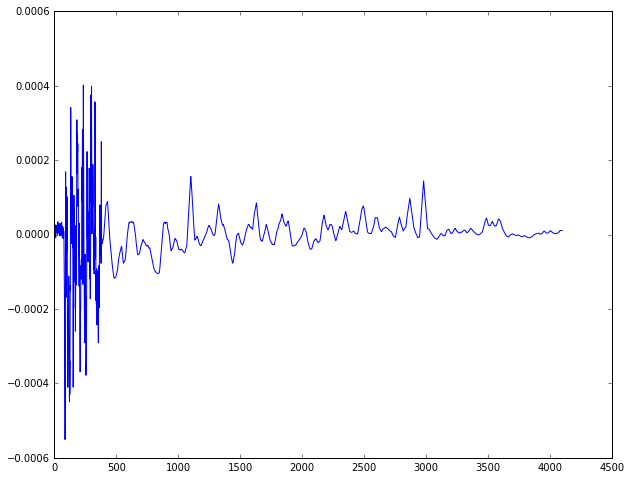

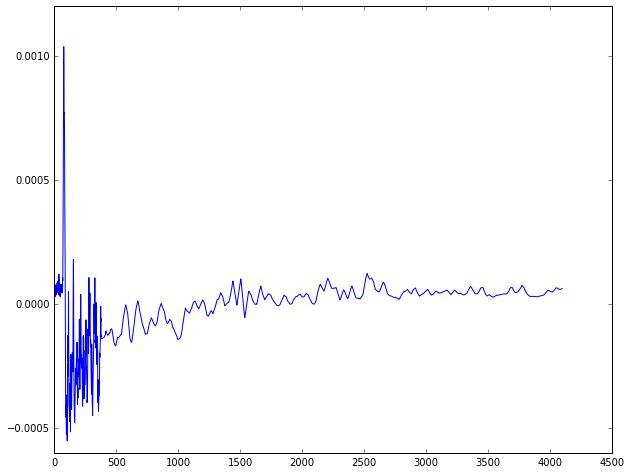

CPU times: user 21.3 s, sys: 3.34 s, total: 24.6 s
Wall time: 24.6 s


In [11]:
%%time
PMTALL_pre_analysis = NORM(file_pre_analysis, tree, data)
PMTALL_ref = NORM(file_ref, tree, data)
Standard = np.average(PMTALL_ref,axis=0)
PMTALL_alpha = NORM(file_alpha, tree, data)

alpha_2 = differ(PMTALL_alpha, Standard)
x = np.arange(0,len(alpha_2[0]),1)
plt.figure()
plt.plot(x,alpha_2[0])
plt.show()
del PMTALL_alpha

ref_2 = differ(PMTALL_ref, Standard)
plt.figure()
plt.plot(x,ref_2[0])
plt.show()
del PMTALL_ref

pre_2 = differ(PMTALL_pre_analysis, Standard)
plt.figure()
plt.plot(x,pre_2[0])
plt.show()
del PMTALL_pre_analysis
pre_2 = np.expand_dims(pre_2,axis=2)

Alpha_2 = sep(alpha_2, ratio, 0)
Ref_2 =sep(ref_2, ratio, 1)
del alpha_2,ref_2

def data_sec(x1,x2,z):
    x11, x12, x13, x14 = x1
    x21, x22, x23, x24 = x2
    y1 = np.concatenate((x11, x21), axis=0)
    y2 = np.concatenate((x12, x22), axis=0)
    y3 = np.concatenate((x13, x23), axis=0)
    y4 = np.concatenate((x14, x24), axis=0)
    iy1 = np.expand_dims(y1, axis=2)
    iy2 = np.expand_dims(y2, axis=2)
    iy3 = keras.utils.to_categorical(y3, z)
    iy4 = keras.utils.to_categorical(y4, z)
    return iy1, iy2, iy3, iy4

train_data2, test_data2, train_label2, test_label2 = data_sec(Alpha_2, Ref_2, 2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 4095, 2)           6         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 2047, 2)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 2047, 2)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4094)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               524160    
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
__________

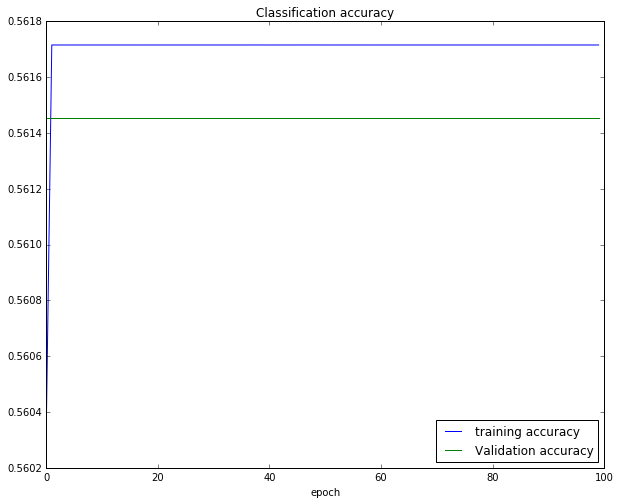

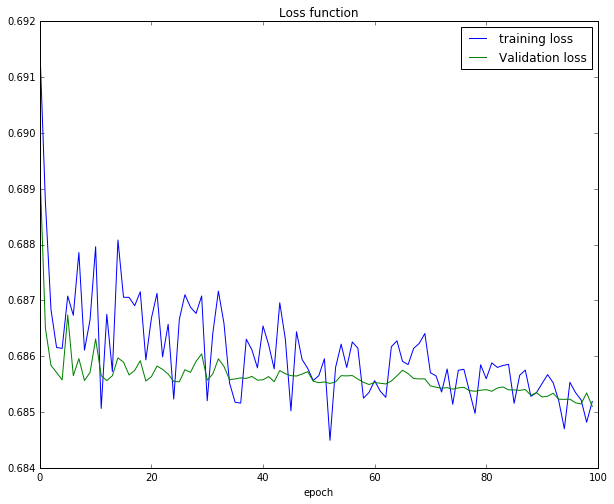

Classification accuracy = 0.561452515964
CPU times: user 6min 13s, sys: 3.33 s, total: 6min 16s
Wall time: 1min 12s


In [14]:
%%time

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization

from keras.regularizers import l2
from keras.optimizers import SGD

model_2 = Sequential()
model_2.add(Conv1D(2, kernel_size=2, activation="relu", input_shape=(len(train_data2[0]),1)))
model_2.add(MaxPooling1D(pool_size=2))
# model_2.add(Conv1D(4, 4, activation="relu"))
# model_2.add(MaxPooling1D(pool_size=4))
# model_2.add(Conv1D(8, 8, activation="relu"))
# model_2.add(MaxPooling1D(pool_size=8))
model_2.add(Dropout(0.2))
model_2.add(Flatten())
model_2.add(Dense(128,activation="relu"))
model_2.add(Dense(64,activation="relu"))
model_2.add(Dense(32,activation="relu"))
model_2.add(Dense(16,activation="relu"))
model_2.add(Dense(8,activation="relu"))
model_2.add(Dense(4,activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(2,activation="softmax"))
model_2.summary()
model_2.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics=['accuracy'])
history_2 = model_2.fit(train_data2, train_label2, batch_size=200, epochs=100, verbose=1, validation_data=(test_data2, test_label2))
score_2 = model_2.evaluate(test_data2, test_label2, verbose=0)
model_2.save("CNN_2.h5")

print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

print(history_2.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history_2.history['acc'],label="training accuracy")
plt.plot(history_2.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history_2.history['loss'],label="training loss")
plt.plot(history_2.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history_2.history['val_acc'][-1])


41200/41259 [============================>.] - ETA: 0s

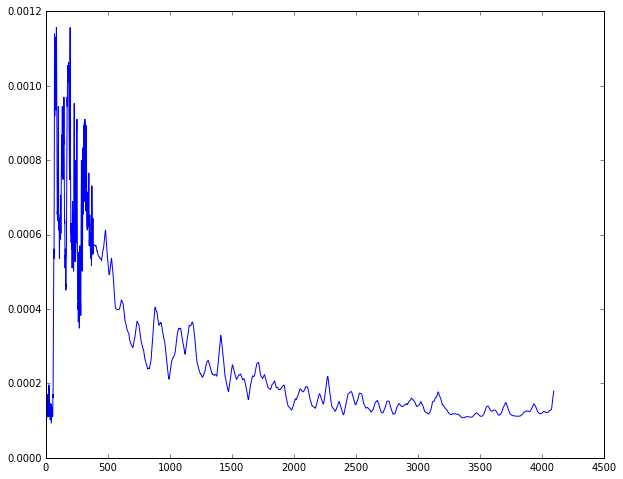

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.57964770e-02   2.75582165e-01   7.05064237e-01   1.58591632e-04
   2.86760763e-03   5.30993857e-04]
alpha, Ref
[ 0.99438453  0.00561545]


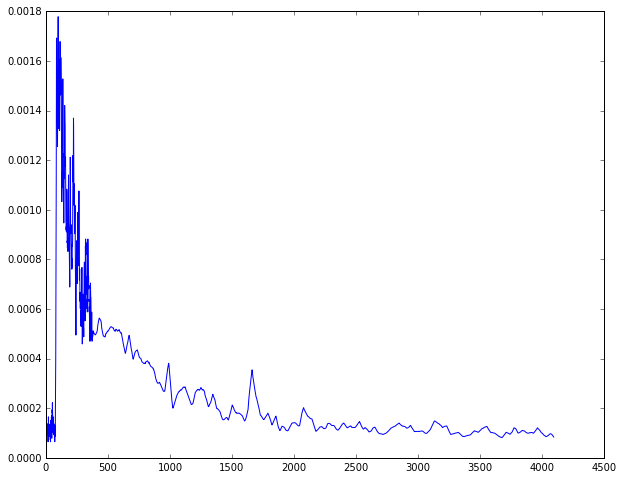

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.72548248e-04   4.32928242e-02   9.51678813e-01   2.92182835e-06
   4.37122025e-03   8.16843822e-05]
alpha, Ref
[  9.99353826e-01   6.46200846e-04]


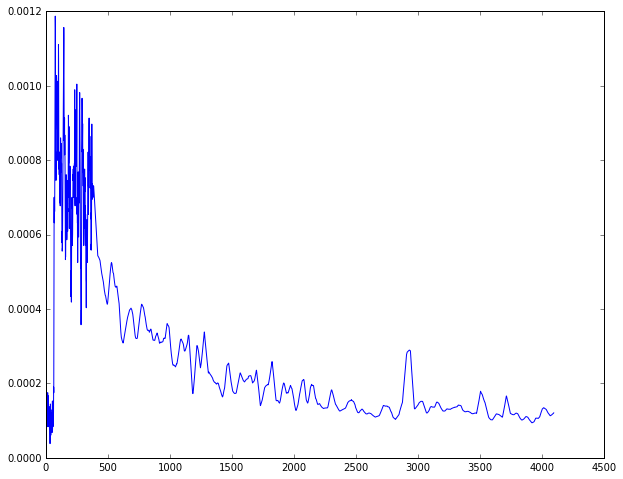

piled, flat, alpha, ls, 
 ls+beta, ref
[  4.68017155e-04   7.62641896e-03   5.40988863e-01   1.25958919e-04
   4.41984624e-01   8.80611502e-03]
alpha, Ref
[ 0.99320024  0.00679971]


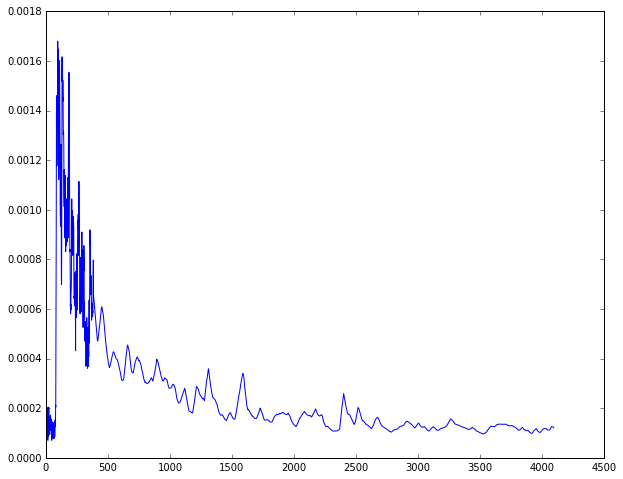

piled, flat, alpha, ls, 
 ls+beta, ref
[  6.47912791e-04   3.98485437e-02   9.58408237e-01   7.67128711e-07
   1.02686416e-03   6.76625350e-05]
alpha, Ref
[  9.99269783e-01   7.30203697e-04]


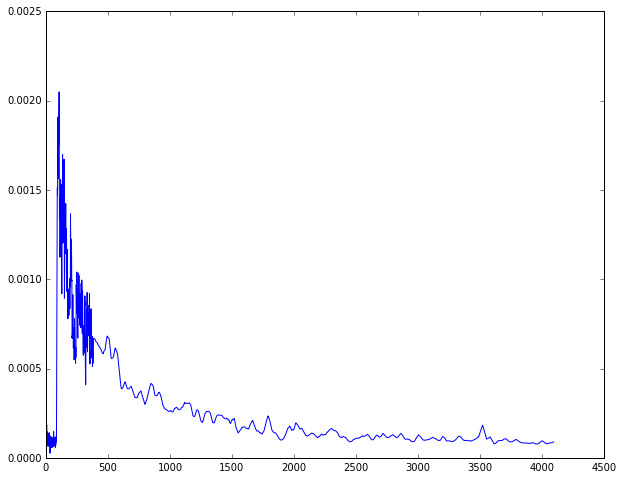

piled, flat, alpha, ls, 
 ls+beta, ref
[  6.15537516e-04   3.94598059e-02   7.81668663e-01   2.26726988e-05
   1.78164542e-01   6.86761923e-05]
alpha, Ref
[ 0.99889368  0.00110635]


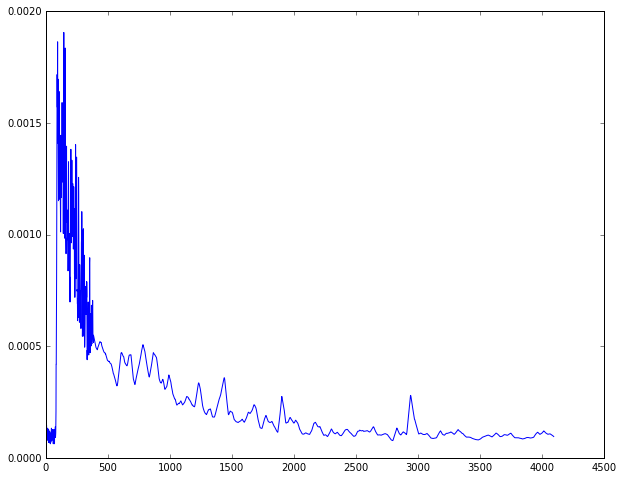

piled, flat, alpha, ls, 
 ls+beta, ref
[  8.31013022e-04   3.60493213e-02   9.60783422e-01   1.72444436e-06
   2.20933696e-03   1.25087216e-04]
alpha, Ref
[ 0.99868327  0.00131678]


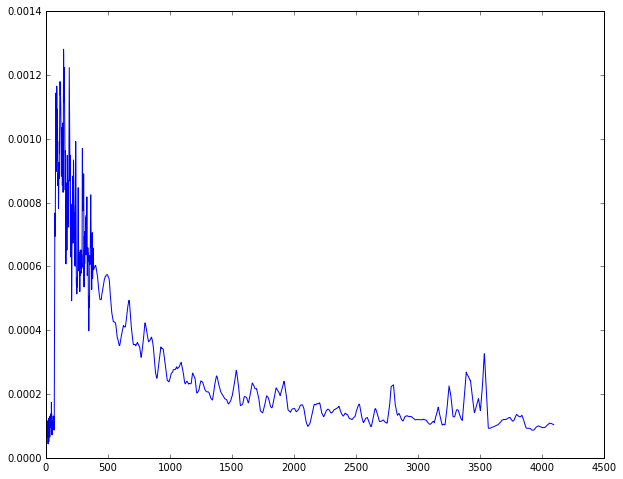

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.59814255e-04   7.40934722e-03   9.79857743e-01   3.10707196e-06
   1.03879925e-02   2.18205154e-03]
alpha, Ref
[ 0.99800938  0.00199065]


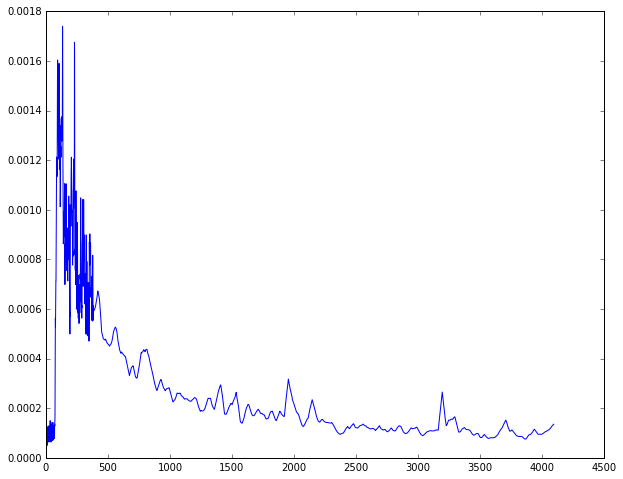

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.46670907e-03   2.28079390e-02   9.71991122e-01   6.03949275e-06
   2.15326599e-03   1.57501292e-03]
alpha, Ref
[ 0.99889565  0.00110434]


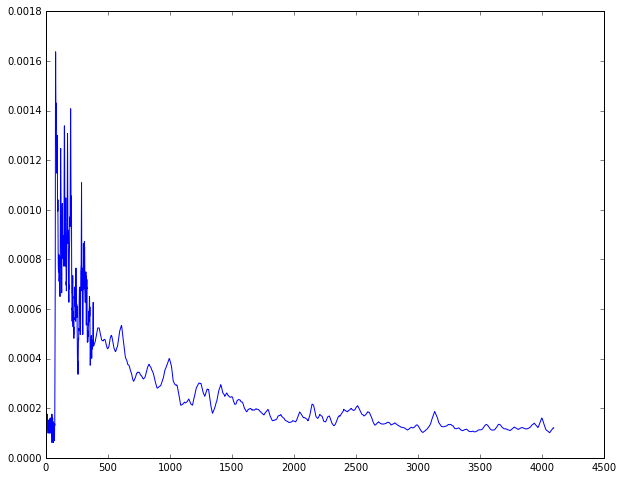

piled, flat, alpha, ls, 
 ls+beta, ref
[ 0.001554    0.03337927  0.78257853  0.0008429   0.17839938  0.00324588]
alpha, Ref
[ 0.99780351  0.00219649]


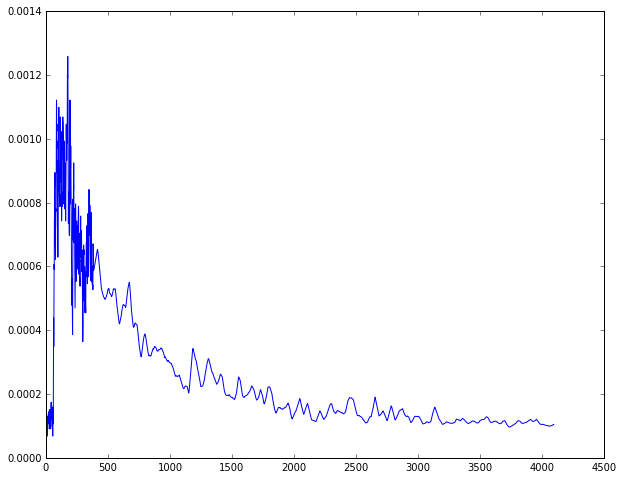

piled, flat, alpha, ls, 
 ls+beta, ref
[  8.41660332e-03   6.04810677e-02   9.21849787e-01   4.07477019e-05
   1.98007980e-03   7.23173842e-03]
alpha, Ref
[ 0.98308867  0.01691132]


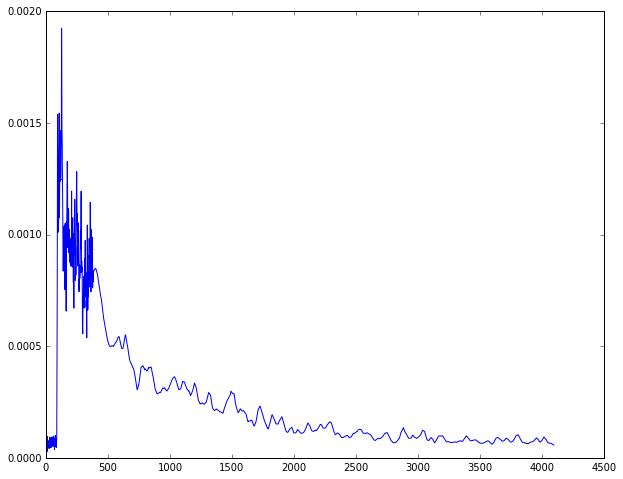

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.66844036e-02   6.51741691e-04   6.94995886e-03   8.20607966e-06
   3.62903898e-04   9.75342751e-01]
alpha, Ref
[ 0.20306544  0.79693455]


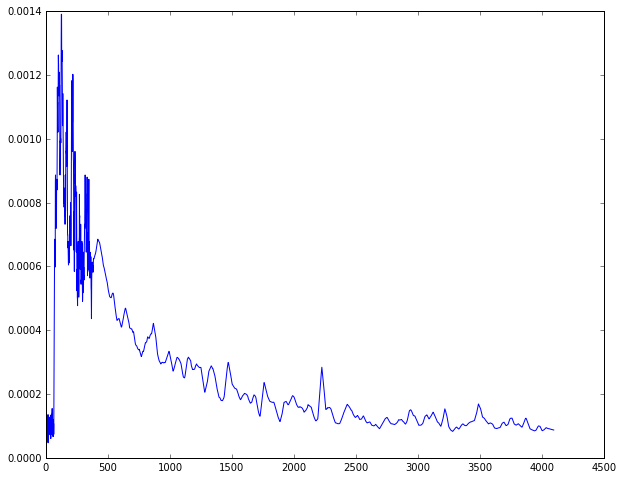

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.68135834e-02   7.97944367e-02   8.80307436e-01   5.69682888e-05
   4.75903915e-04   1.25517510e-02]
alpha, Ref
[ 0.98744595  0.01255408]


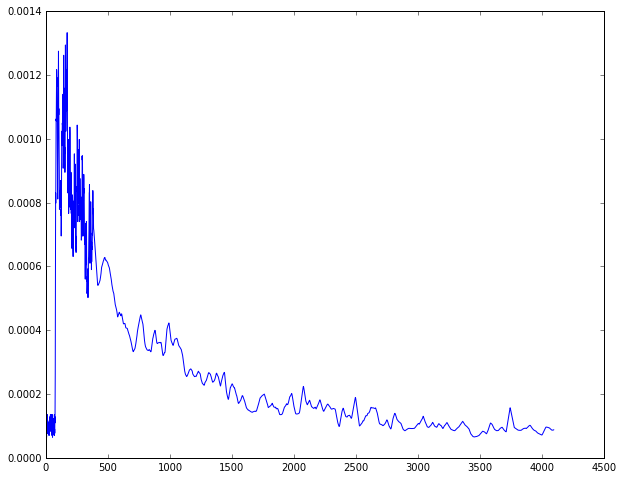

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.73035669e-02   8.19549989e-03   8.54246840e-02   1.29114604e-04
   4.68629086e-03   8.64260793e-01]
alpha, Ref
[ 0.62847316  0.3715269 ]


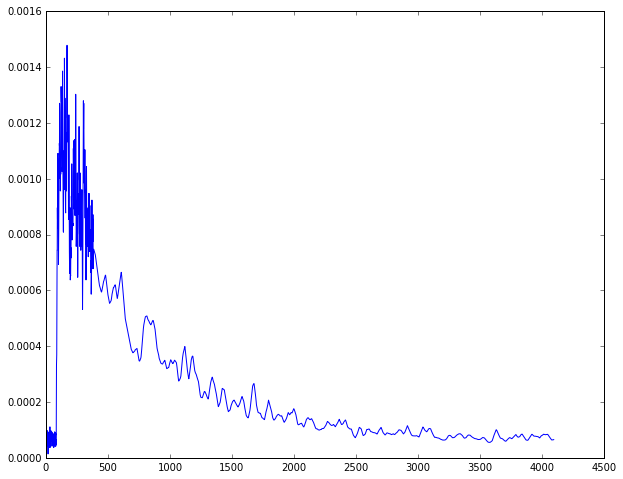

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.81510738e-03   6.65920525e-05   6.02482061e-04   2.64917066e-08
   7.26357541e-07   9.93515015e-01]
alpha, Ref
[ 0.00456352  0.99543649]


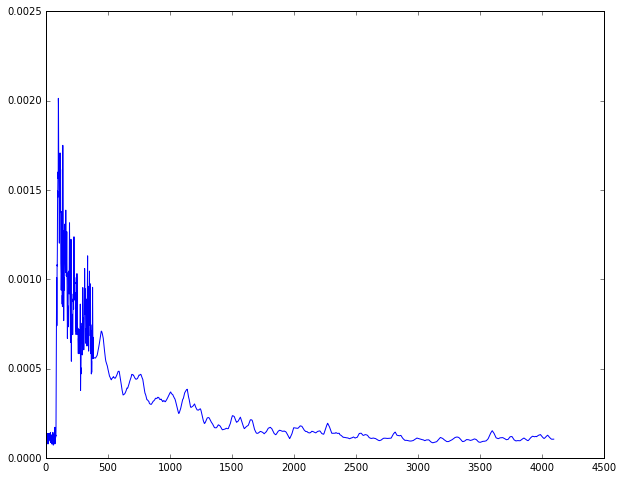

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.38654921e-03   5.65506816e-02   9.17803168e-01   1.61802363e-05
   2.40438953e-02   1.99553528e-04]
alpha, Ref
[ 0.99845123  0.0015488 ]


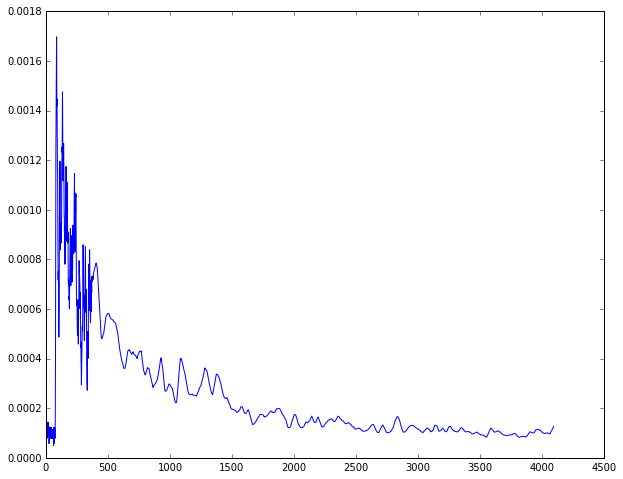

piled, flat, alpha, ls, 
 ls+beta, ref
[ 0.0348209   0.04409125  0.75448632  0.00274445  0.08151509  0.0823421 ]
alpha, Ref
[ 0.91880876  0.08119129]


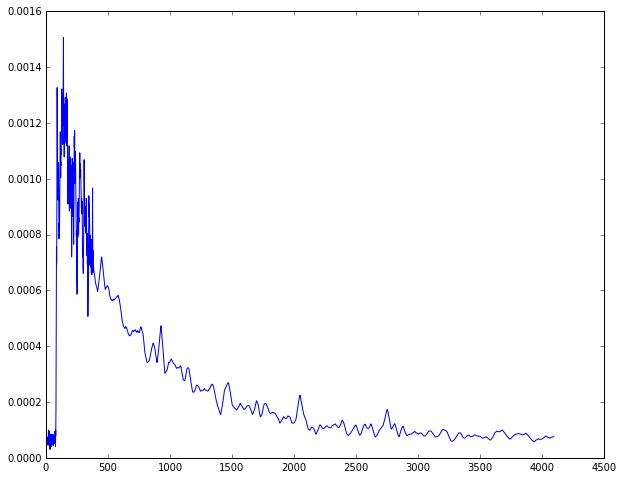

piled, flat, alpha, ls, 
 ls+beta, ref
[  4.90787765e-03   7.59343748e-05   8.46231473e-04   1.84295587e-07
   1.15868324e-05   9.94158149e-01]
alpha, Ref
[ 0.02671305  0.97328693]


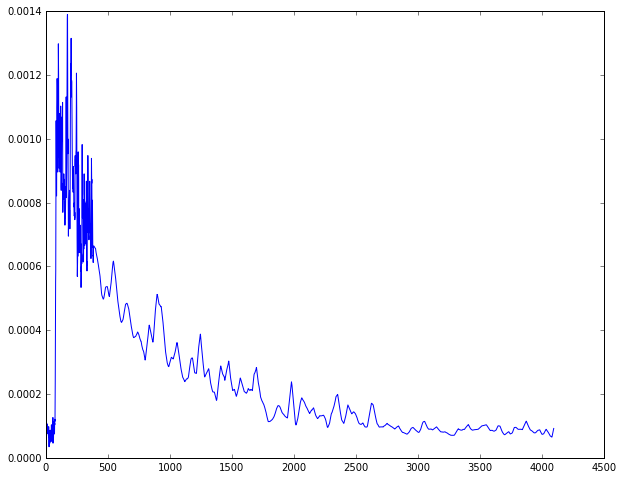

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.05114291e-03   2.51667923e-04   5.69582405e-03   5.43613794e-07
   3.10902251e-05   9.90969837e-01]
alpha, Ref
[ 0.12193402  0.878066  ]


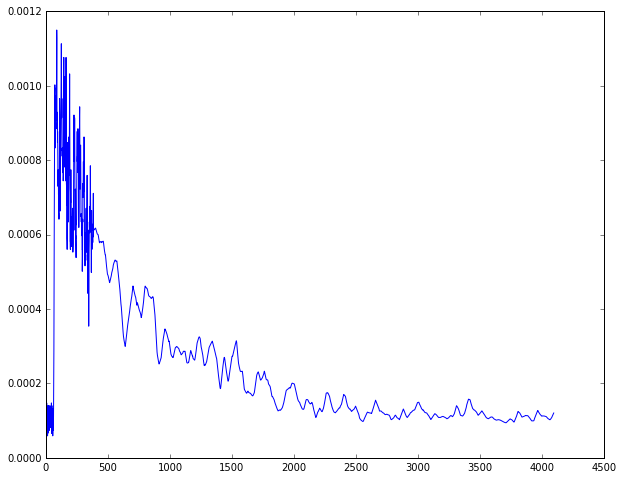

piled, flat, alpha, ls, 
 ls+beta, ref
[  8.91141780e-03   3.31032500e-02   7.93224096e-01   3.00212152e-04
   6.51433989e-02   9.93176401e-02]
alpha, Ref
[ 0.89267987  0.1073202 ]


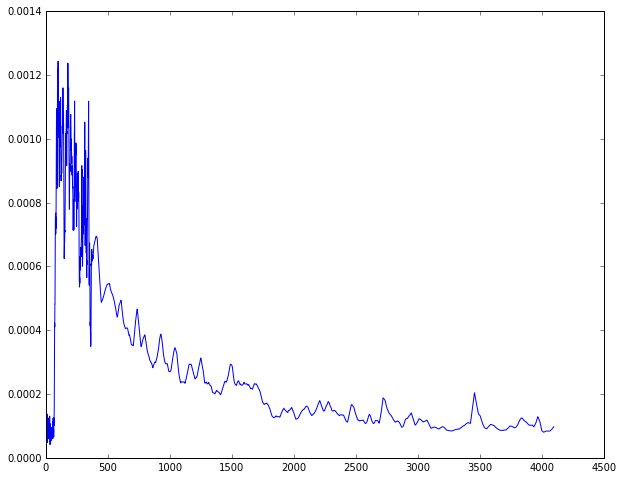

piled, flat, alpha, ls, 
 ls+beta, ref
[  9.30117536e-03   1.59828551e-02   8.35003257e-01   2.78050920e-05
   4.93572676e-04   1.39191449e-01]
alpha, Ref
[ 0.96924233  0.03075765]
CPU times: user 36.6 s, sys: 2.22 s, total: 38.8 s
Wall time: 16.8 s


In [3]:
%%time
indices = np.argmax(pred,axis=1)

model_2 = load_model("CNN_2.h5")
pred_2 = model_2.predict(pre_2,batch_size=50,verbose=1)

dummy = 0
for i in range(len(PMTALL_pre_analysis)):
    k = np.random.randint(len(PMTALL_pre_analysis))
    if indices[k]==2 or indices[k]==5 :
        plt.figure()
        plt.plot(x,PMTALL_pre_analysis[k])
        plt.show()
        print("piled, flat, alpha, ls, \n ls+beta, ref")
        print(pred[k])
        print("alpha, Ref")
        print(pred_2[k])
        dummy += 1
    if dummy == 20:
        break

# Labelling data

Produce a set of numbers that represents the classified groups. 

for now produce a histogram in python
write it into a root file format(later) 

# Problems required to overcome

For model_2, Initialization of our problem seem to be a big problem hinders the learning progress of our 2nd CNN network

0.9985729455947876
all (41259,)


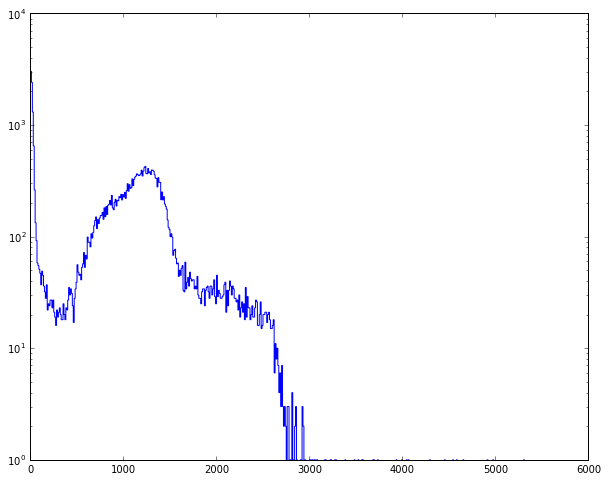

piled (29,)


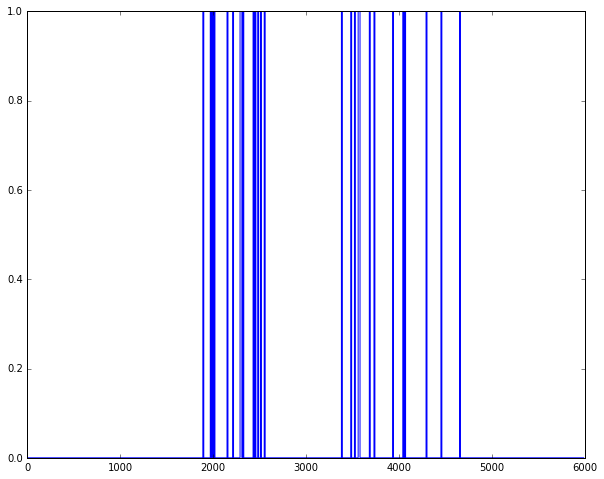

clock events (19581,)


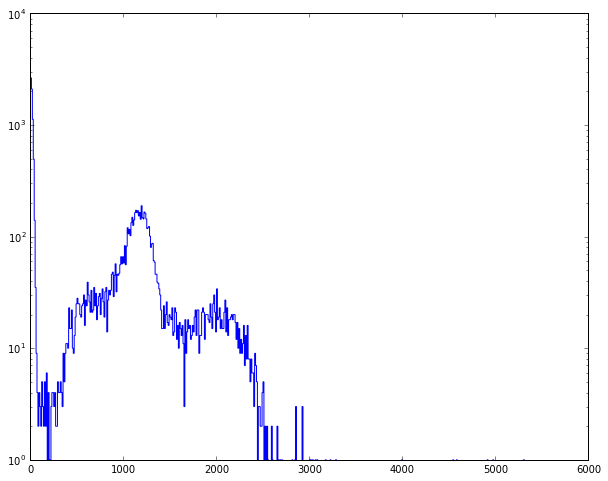

alpha (3705,)


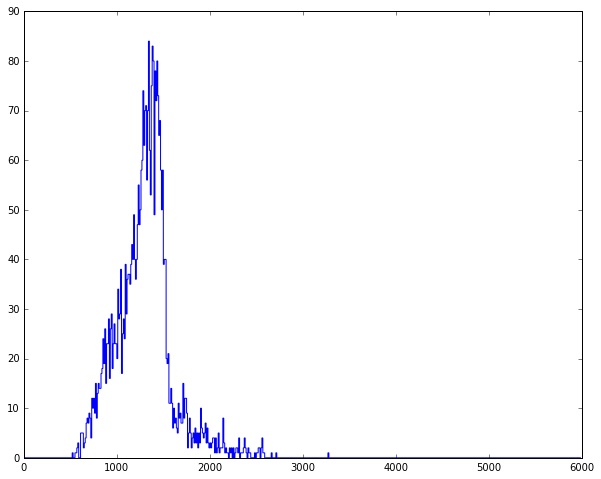

LS (3892,)


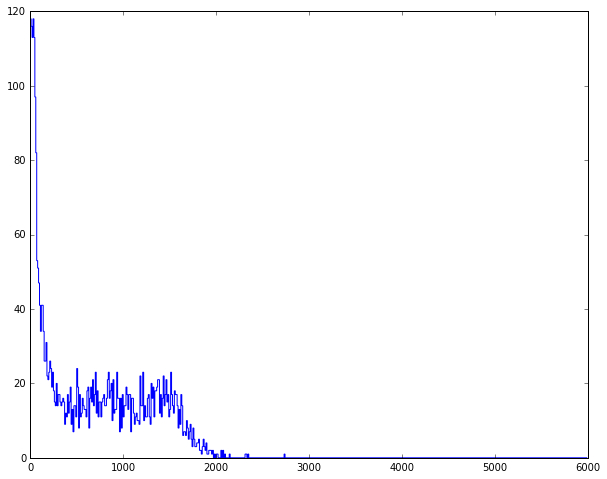

LS+beta (13774,)


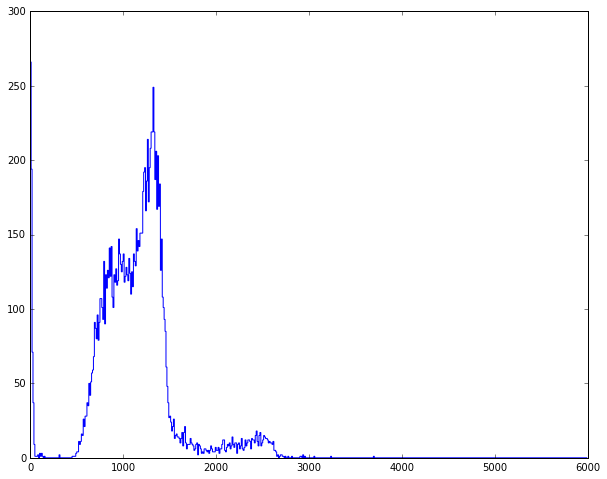

Ref (266,)


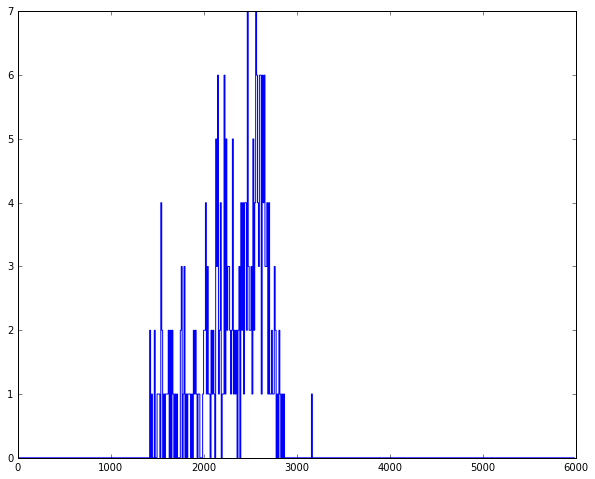

Uncertain (12,)


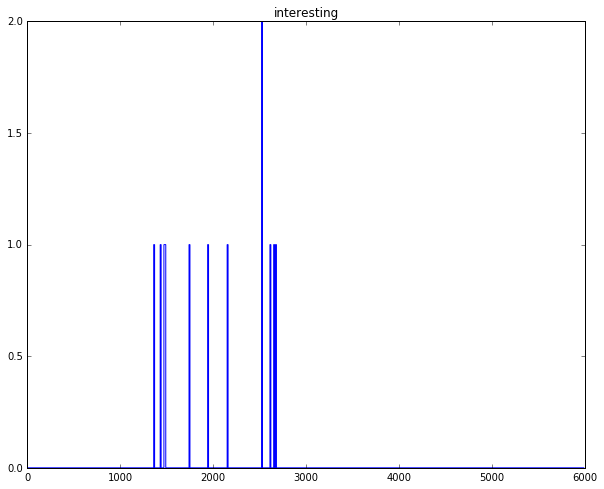

In [7]:
# plt.rcParams['figure.figsize'] = 5.0, 4.0

indices_1 = np.argmax(pred, axis=1)
indices_2 = np.argmax(pred_2, axis=1)

pred_2_error = np.diff(pred_2,axis=1)
print(abs(float(pred_2_error[0])))

error = np.zeros(len(PMTALL_pre_analysis))
for i in range(len(pred_2)):
    if abs(float(pred_2_error[i]))<0.1:
        error[i] = 1
    else:
        error[i] = 0
        
groups = np.zeros(len(PMTALL_pre_analysis))

for i in range(len(PMTALL_pre_analysis)):
    if indices_1[i]==2 or indices_1[i]==5:
        if error[i]==1:
            groups[i]=6
        else:
            if indices_2[i]==0:
                groups[i]=2
            if indices_2[i]==1:
                groups[i]=5
    else:
        groups[i]=indices_1[i]

# for i in range(len(PMTALL_pre_analysis)):
#     if indices_1[i]==2 or indices_1[i]==5:
#         if indices_2[i]==0:
#             groups[i]=2
#         if indices_2[i]==1:
#             groups[i]=5
#         else:
#             groups[i]=indices_1[i]
#     else:
#         groups[i]=indices_1[i]

energy = read_root("CAT009-230-001.root", tree, columns=["Energy"],flatten=["Energy"])
l,h = energy.shape
li=int(l/3)
def reshape_Energy(x,n,l):
    return x.Energy.values.reshape(n,l)
energy1 = reshape_Energy(energy,li,3)
Energy = energy1[:,1]
Energy = np.expand_dims(Energy, axis=1)

bins = np.arange(0,6000,10)
counts0 = np.array([])
counts1 = np.array([])
counts2 = np.array([])
counts3 = np.array([])
counts4 = np.array([])
counts5 = np.array([])
counts6 = np.array([])
all_counts = np.array([])

for i in range(len(PMTALL_pre_analysis)):
    if groups[i]==0:
        counts0 = np.concatenate((counts0, Energy[i]), axis=0)
    if groups[i]==1:
        counts1 = np.concatenate((counts1, Energy[i]), axis=0)
    if groups[i]==2:
        counts2 = np.concatenate((counts2, Energy[i]), axis=0)
    if groups[i]==3:
        counts3 = np.concatenate((counts3, Energy[i]), axis=0)
    if groups[i]==4:
        counts4 = np.concatenate((counts4, Energy[i]), axis=0)
    if groups[i]==5:
        counts5 = np.concatenate((counts5, Energy[i]), axis=0)
    if groups[i]==6:
        counts6 = np.concatenate((counts6, Energy[i]), axis=0)
    all_counts = np.concatenate((all_counts, Energy[i]), axis=0)

print("all",all_counts.shape)
plt.figure()
plt.hist(all_counts,stacked=False,bins=bins,histtype="step")
plt.yscale("log")
plt.show()    

print("piled",counts0.shape)
plt.figure()
plt.hist(counts0,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("clock events",counts1.shape)
plt.figure()
plt.hist(counts1,stacked=False,bins=bins,histtype="step")
plt.yscale("log")
plt.show()

print("alpha",counts2.shape)
plt.figure()
plt.hist(counts2,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("LS",counts3.shape)
plt.figure()
plt.hist(counts3,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("LS+beta",counts4.shape)
plt.figure()
plt.hist(counts4,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("Ref",counts5.shape)
plt.figure()
plt.hist(counts5,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("Uncertain",counts6.shape)
plt.figure()
plt.title("interesting")
plt.hist(counts6,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

# Beyond 3000keV

This definately requires more work as I extract the high probabilty for all possible outcome.

For cases where the probaility is not quite the highest, 0.5 class A and 0,4 class B. obviously there is some overlap in this case. I have to figure out a way to do this code, not a striaghtforward to implement, have to figure it out!!

TO simplify the amount of data to go through I considered only energy above 3000keV

In [3]:
%%time

energy_test = read_root("TEST.root", "tree", columns=["Energy"], flatten=["Energy"])

l_test,h = energy_test.shape
l_test=int(l_test/3)

def reshape_Energy(x,n,l):
    return x.Energy.values.reshape(n,l)

energy_test = reshape_Energy(energy_test,l_test,3)

PMTALL_test = NORM("TEST.root", "tree", "PMTALL")

PMTALL_diff_test = differ(PMTALL_test, Standard)

Energy_test = np.expand_dims(energy_test[:,1], axis=1)

from keras.models import load_model
model = load_model("CNN_1.h5")
model_2 = load_model("CNN_2.h5")

data_test_1 = np.expand_dims(PMTALL_test, axis=2)
data_test_2 = np.expand_dims(PMTALL_diff_test, axis=2)

del PMTALL_test, PMTALL_diff_test

predict_test_1 = model.predict(data_test_1, batch_size=50, verbose=1)
predict_test_2 = model_2.predict(data_test_2, batch_size=50, verbose=1)

del data_test_1, data_test_2

test_out_1 = np.argmax(predict_test_1, axis=1)
test_out_2 = np.argmax(predict_test_2, axis=1)

print(test_out_2)
pred_2_error2 = np.diff(predict_test_2,axis=1)

error2 = np.zeros(len(Energy_test))
for i in range(len(pred_2_error2)):
    if abs(float(pred_2_error2[i]))<0.1:
        error2[i] = 1
    else:
        error2[i] = 0

test_out = np.zeros(len(Energy_test))
for i in range(len(Energy_test)):
#     if test_out_1[i]==2 or test_out_1[i]==5:
#         print("got")
#         if error2[i] == 1:
#             test_out[i] = 6
#         else:
#             if test_out_2[i] == 0:
#                 test_out[i] = 2
#             if test_out_2[i] == 1:
#                 test_out[i] = 5
#     else:
    test_out[i] = test_out_1[i]
        
### MOD this need ways to extract ambiguous cases
# for i in range(len(Energy_test)):
#     if test_out_1[i]==2 or test_out_1[i]==5:
#         if test_out_2[i]==0:
#             test_out[i]=2
#         if test_out_2[i]==1:
#             test_out[i]=5
#     else:
#         test_out[i]=test_out_1[i]




142115/142115 [==============================] - 27s    
[0 1 0 ..., 0 0 0]
CPU times: user 11min 45s, sys: 1min 50s, total: 13min 36s
Wall time: 5min 43s



 all (142115,)


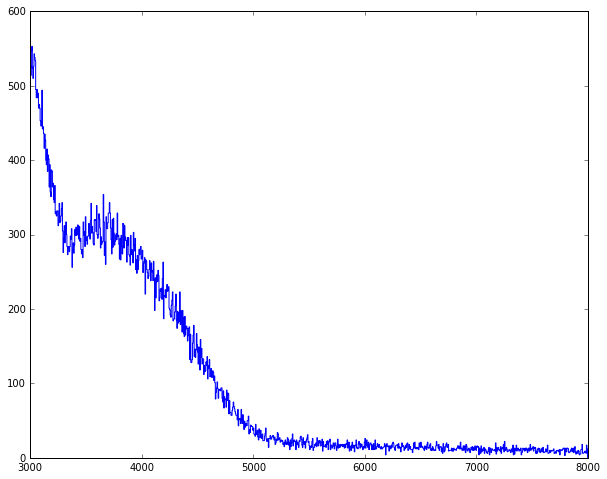


 piled (125,)


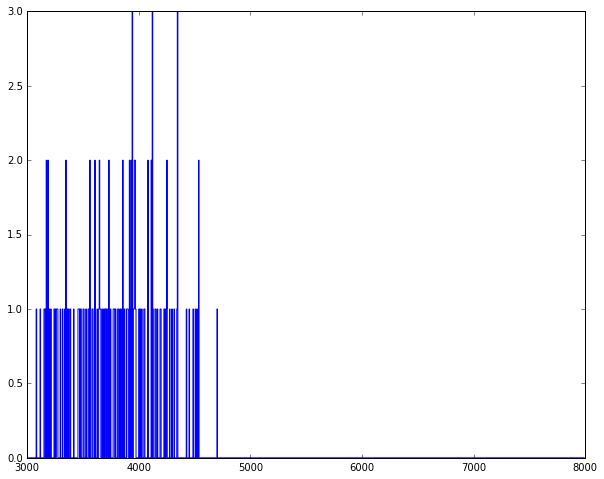

clock events? (139376,)


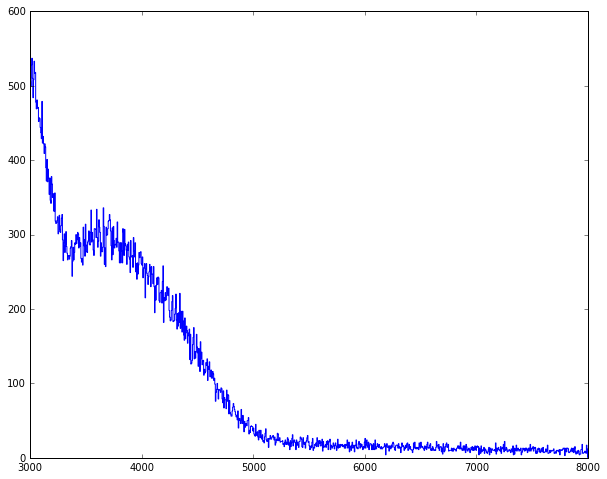

alpha? (0,)


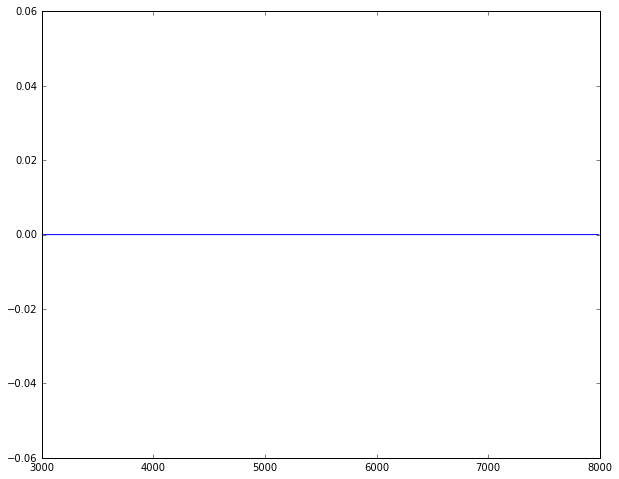

LS? (2598,)


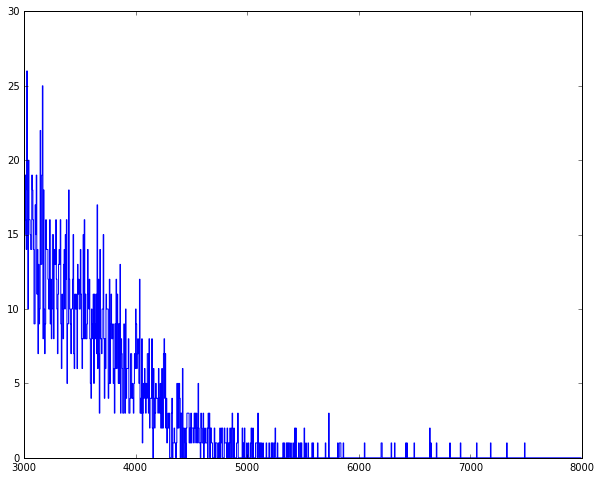

LS_beta (16,)


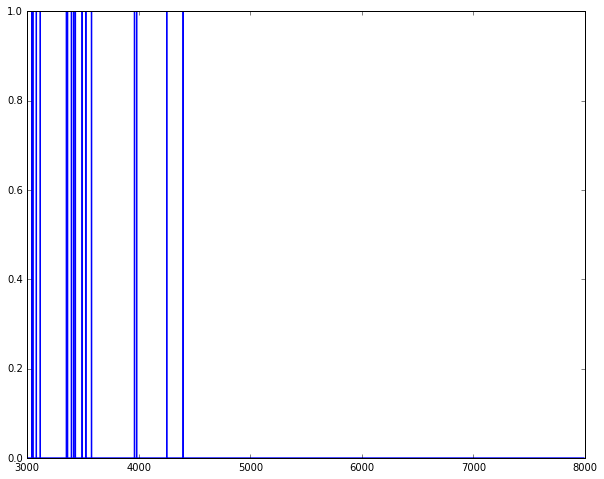

Ref (0,)


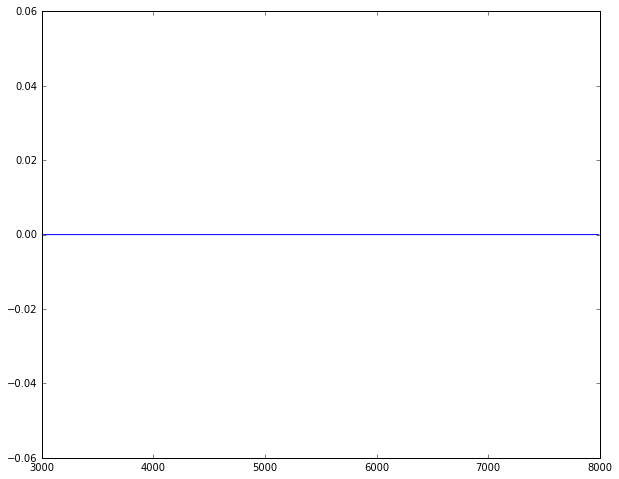

uncertain (0,)


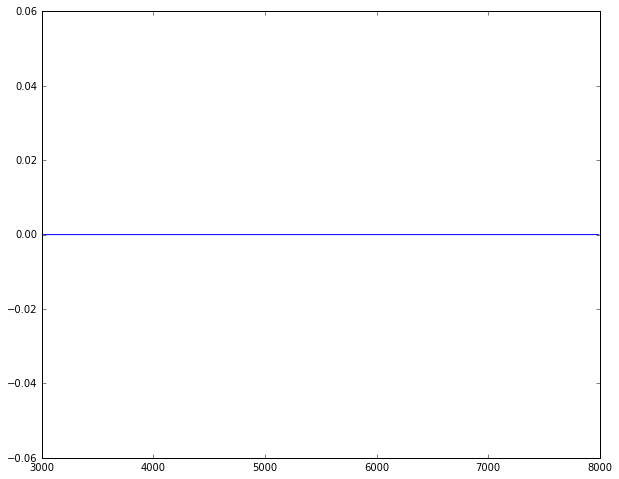

In [4]:
bins = np.arange(3000,8000,5)
counts0 = np.array([])
counts1 = np.array([])
counts2 = np.array([])
counts3 = np.array([])
counts4 = np.array([])
counts5 = np.array([])
counts6 = np.array([])
all_counts = np.array([])

for i in range(len(test_out)):
    if test_out[i]==0:
        counts0 = np.concatenate((counts0, Energy_test[i]), axis=0)
    if test_out[i]==1:
        counts1 = np.concatenate((counts1, Energy_test[i]), axis=0)
    if test_out[i]==2:
        counts2 = np.concatenate((counts2, Energy_test[i]), axis=0)
    if test_out[i]==3:
        counts3 = np.concatenate((counts3, Energy_test[i]), axis=0)
    if test_out[i]==4:
        counts4 = np.concatenate((counts4, Energy_test[i]), axis=0)
    if test_out[i]==5:
        counts5 = np.concatenate((counts5, Energy_test[i]), axis=0)
    if test_out[i]==6:
        counts6 = np.concatenate((counts6, Energy_test[i]), axis=0)
for i in range(len(test_out)):
    all_counts = np.concatenate((all_counts, Energy_test[i]), axis=0)

print("\n all", all_counts.shape)
plt.figure()
plt.hist(all_counts, stacked=False, bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("\n piled", counts0.shape)
plt.figure()
plt.hist(counts0, stacked=False, bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("clock events?",counts1.shape)
plt.figure()
plt.hist(counts1, stacked=False, bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("alpha?",counts2.shape)
plt.figure()
plt.hist(counts2, stacked=False, bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("LS?",counts3.shape)
plt.figure()
plt.hist(counts3,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("LS_beta",counts4.shape)
plt.figure()
plt.hist(counts4,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("Ref",counts5.shape)
plt.figure()
plt.hist(counts5,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

print("uncertain",counts6.shape)
plt.figure()
plt.hist(counts6,stacked=False,bins=bins,histtype="step")
# plt.yscale("log")
plt.show()

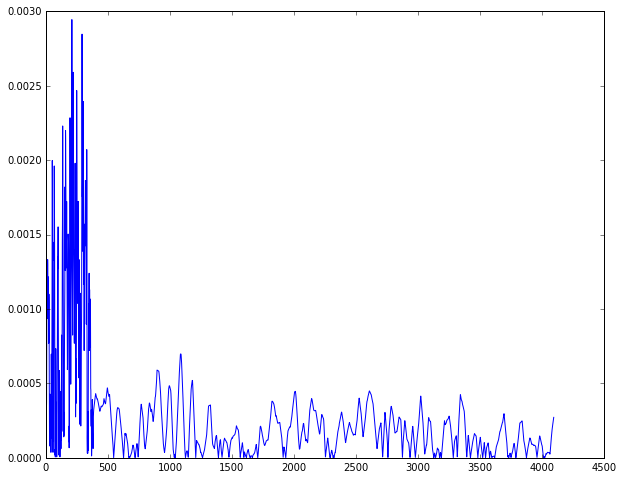

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.13390887e-34   1.00000000e+00   1.01241337e-37   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


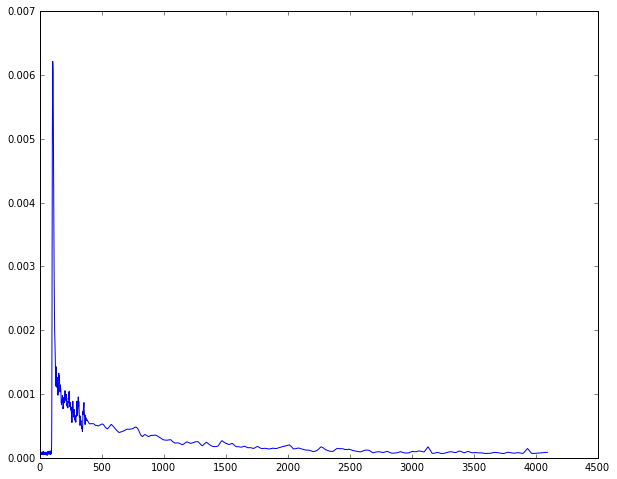

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.53087889e-08   1.00000000e+00   7.79217203e-15   1.98594011e-15
   2.71915152e-16   5.86506431e-28]


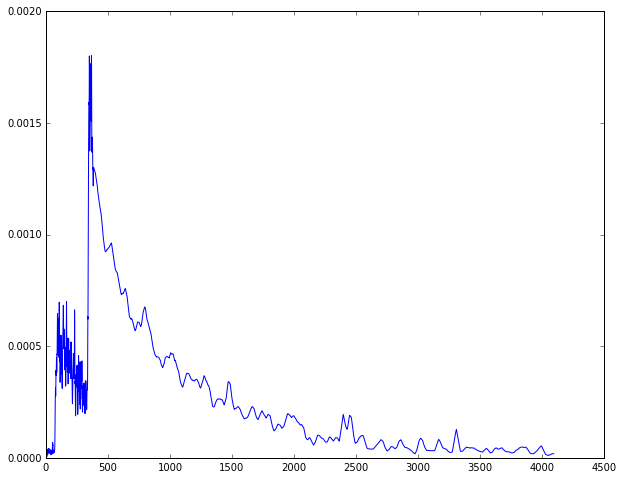

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.63716760e-19   1.00000000e+00   1.07949359e-23   8.36300171e-30
   4.06329424e-35   0.00000000e+00]


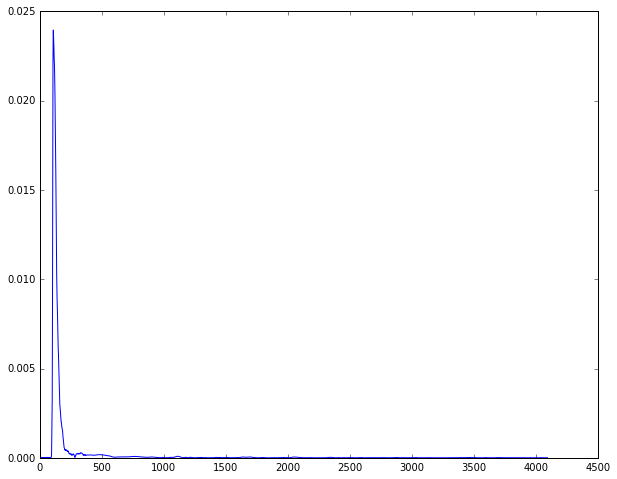

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.14015231e-16   1.00000000e+00   2.71722579e-14   6.82289412e-31
   2.22583184e-34   0.00000000e+00]


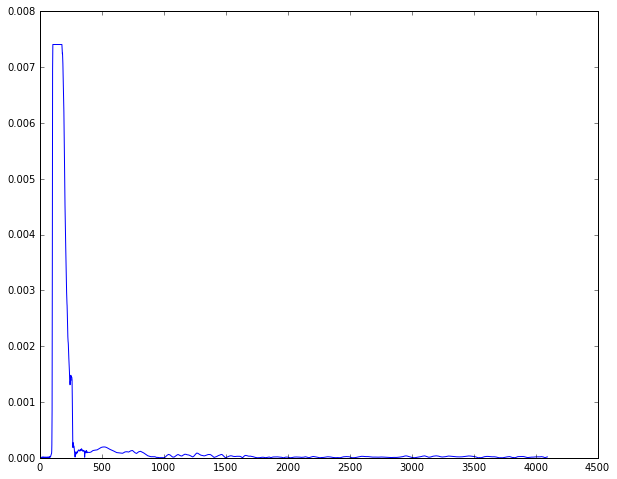

piled, flat, alpha, ls, 
 ls+beta, ref
[  4.24828078e-22   1.00000000e+00   5.36124739e-20   9.84178972e-35
   1.97425533e-37   0.00000000e+00]


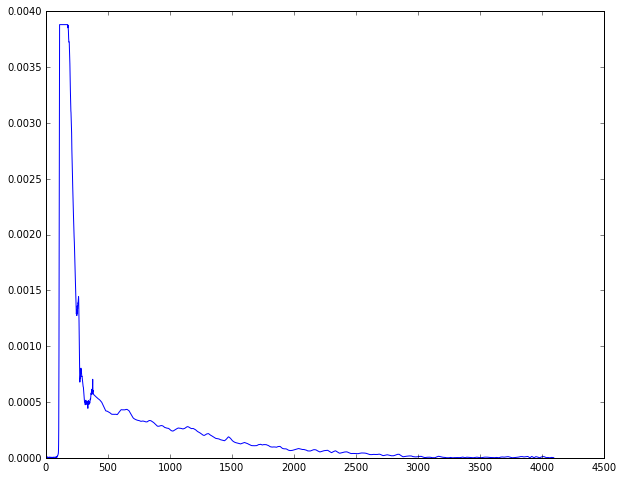

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.93360597e-16   1.00000000e+00   3.90587935e-17   2.71850638e-25
   6.56647801e-29   0.00000000e+00]


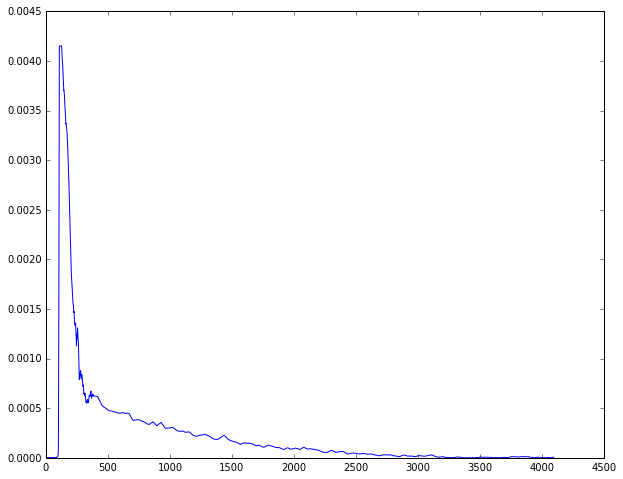

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.77949489e-14   1.00000000e+00   1.32039604e-14   9.29660132e-22
   6.71444876e-24   9.97710695e-37]


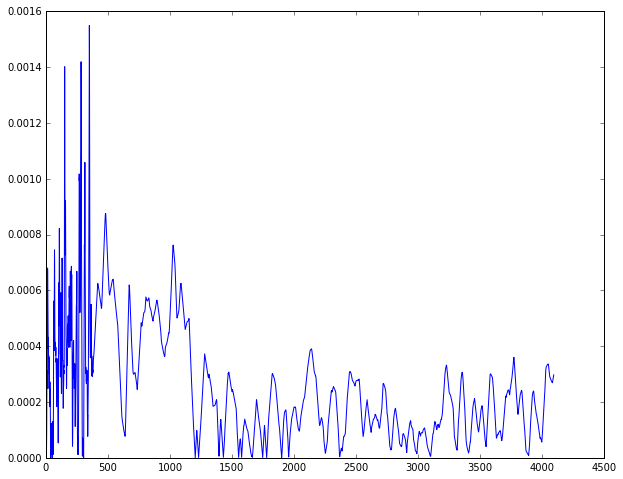

piled, flat, alpha, ls, 
 ls+beta, ref
[  8.81072024e-28   1.00000000e+00   2.30343849e-32   5.77938111e-35
   0.00000000e+00   0.00000000e+00]


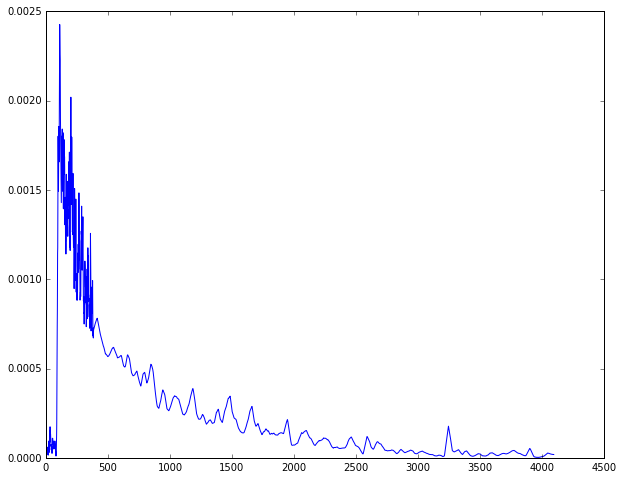

piled, flat, alpha, ls, 
 ls+beta, ref
[  4.82958175e-16   1.00000000e+00   5.68693780e-20   9.24252550e-24
   1.26089297e-28   0.00000000e+00]


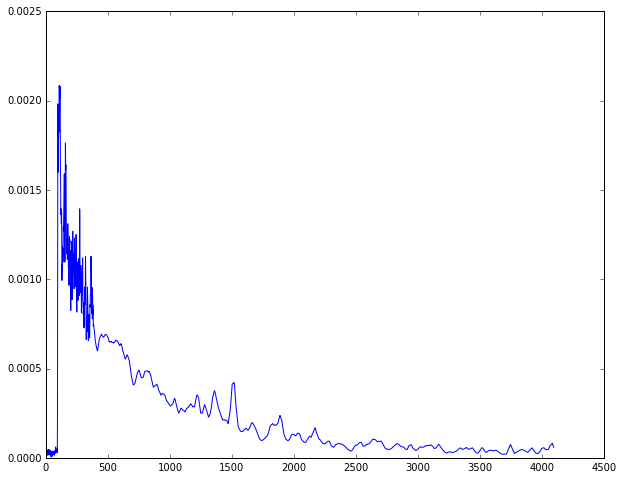

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.47018438e-18   1.00000000e+00   9.75264004e-23   6.21287682e-26
   1.24768052e-31   0.00000000e+00]


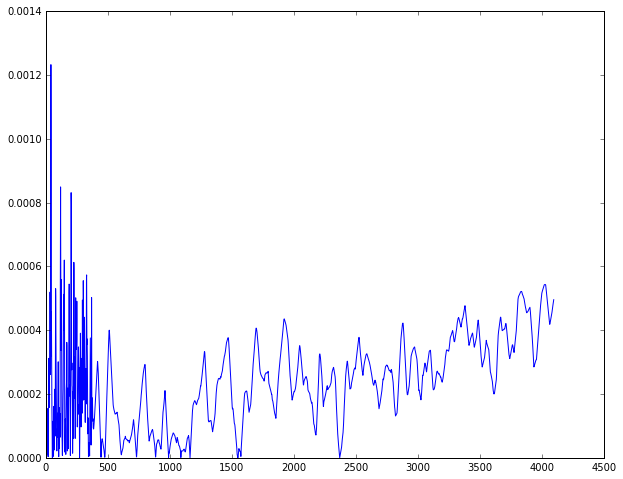

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.64523467e-22   1.00000000e+00   2.95129652e-23   3.29786053e-18
   3.89436100e-26   0.00000000e+00]


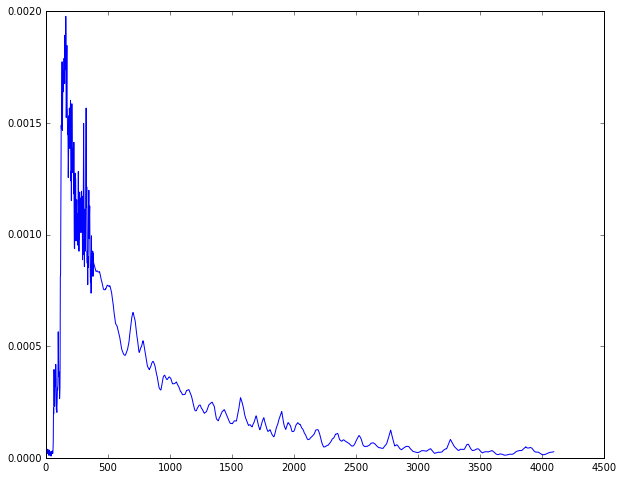

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.09998792e-15   1.00000000e+00   5.36354373e-18   1.17938608e-21
   7.09256766e-26   0.00000000e+00]


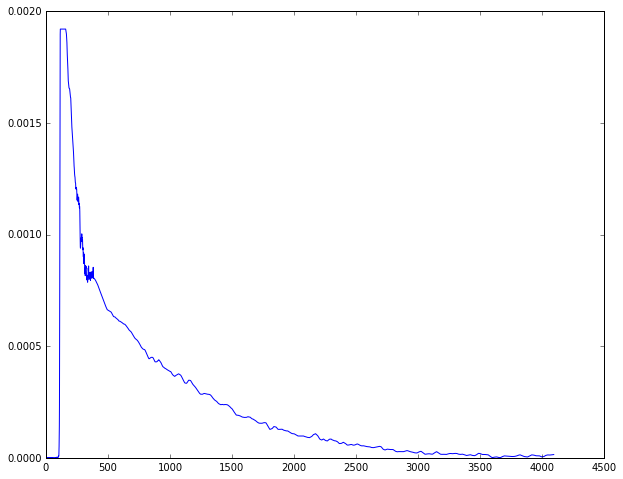

piled, flat, alpha, ls, 
 ls+beta, ref
[  4.80398886e-15   1.00000000e+00   2.48831128e-18   5.79768084e-22
   2.13342917e-26   0.00000000e+00]


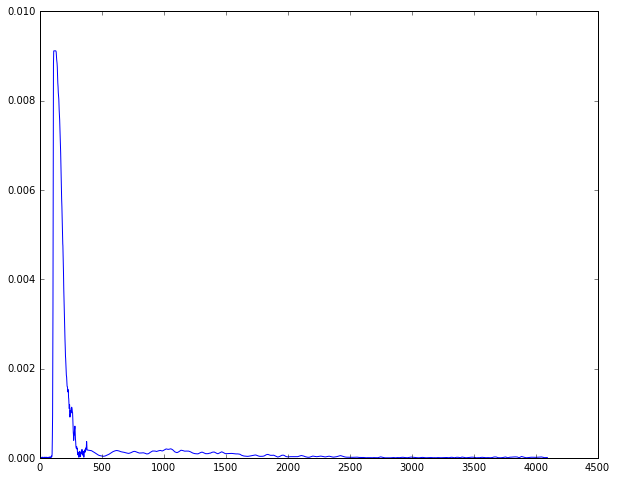

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.01493613e-24   1.00000000e+00   8.62431967e-24   7.27572234e-37
   0.00000000e+00   0.00000000e+00]


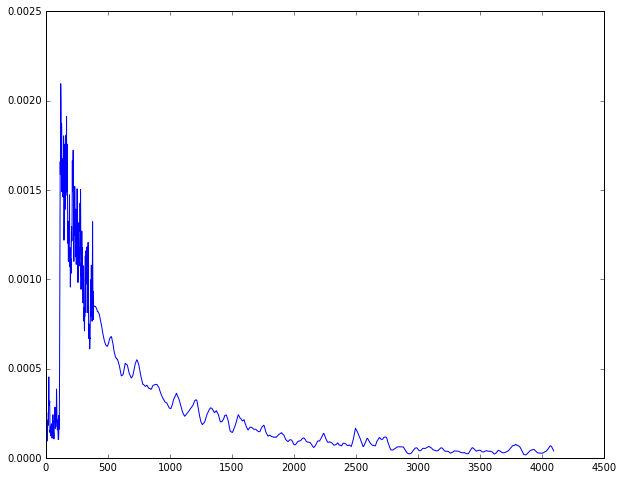

piled, flat, alpha, ls, 
 ls+beta, ref
[  8.05023024e-23   1.00000000e+00   8.50521382e-28   2.74134319e-33
   0.00000000e+00   0.00000000e+00]


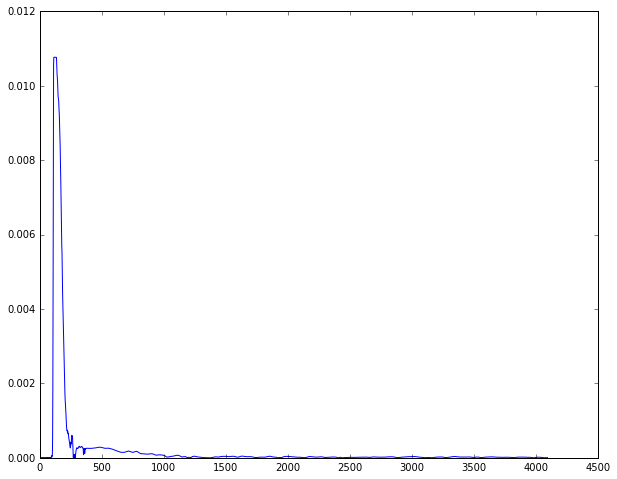

piled, flat, alpha, ls, 
 ls+beta, ref
[  9.13699376e-27   1.00000000e+00   1.54131354e-25   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


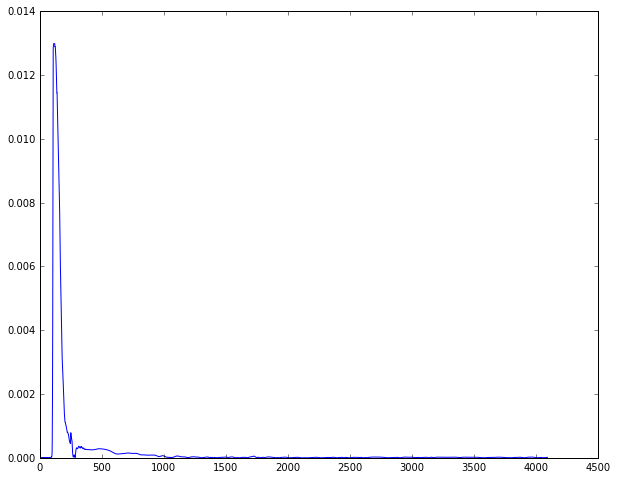

piled, flat, alpha, ls, 
 ls+beta, ref
[  7.00578055e-22   1.00000000e+00   1.64278509e-19   8.89626982e-35
   8.79077637e-36   0.00000000e+00]


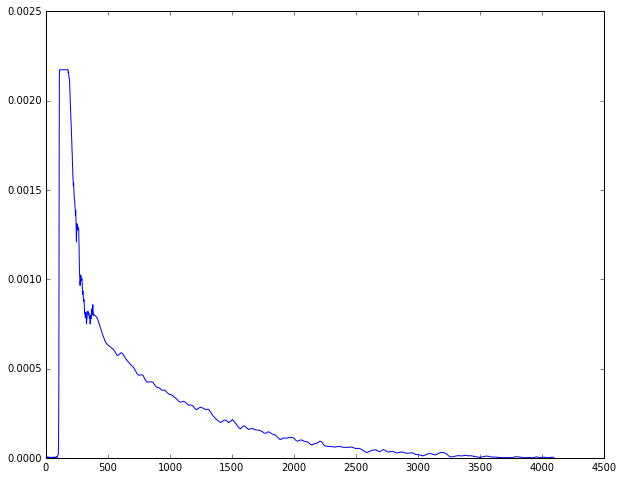

piled, flat, alpha, ls, 
 ls+beta, ref
[  7.67883546e-14   1.00000000e+00   2.95396546e-16   6.63430961e-21
   9.08386447e-25   7.35910332e-36]


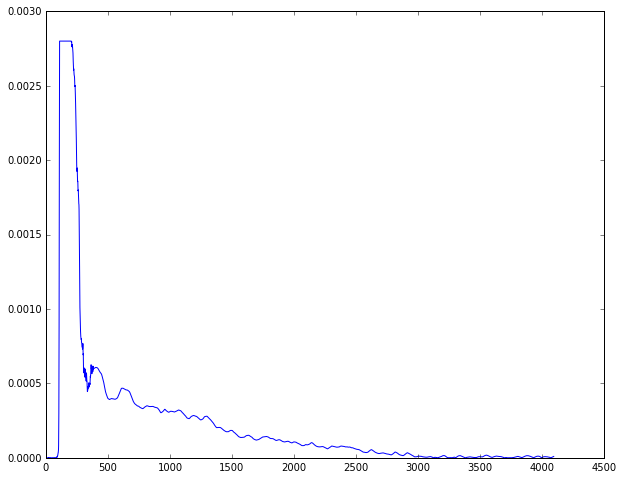

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.31022663e-14   1.00000000e+00   2.00934095e-16   1.47682177e-23
   1.39749868e-27   2.63583591e-37]


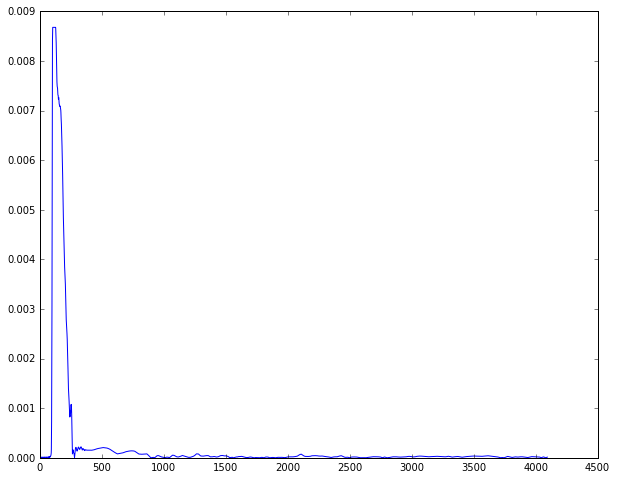

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.56188088e-18   1.00000000e+00   1.45159297e-15   6.51594537e-30
   3.03503162e-30   0.00000000e+00]


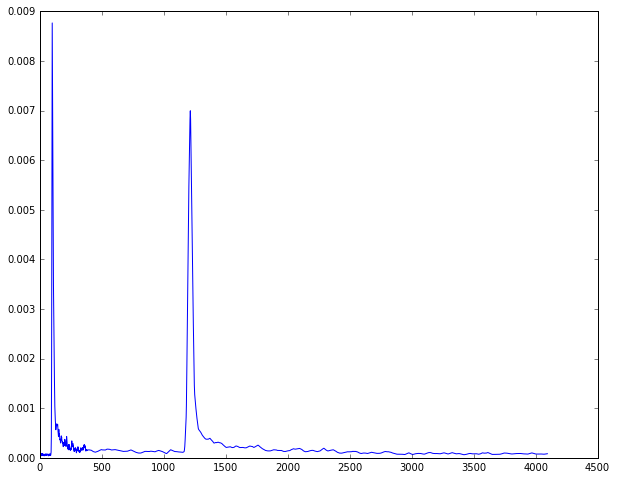

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.51733023e-21   1.00000000e+00   1.41058406e-26   3.98472014e-34
   1.74205403e-38   0.00000000e+00]


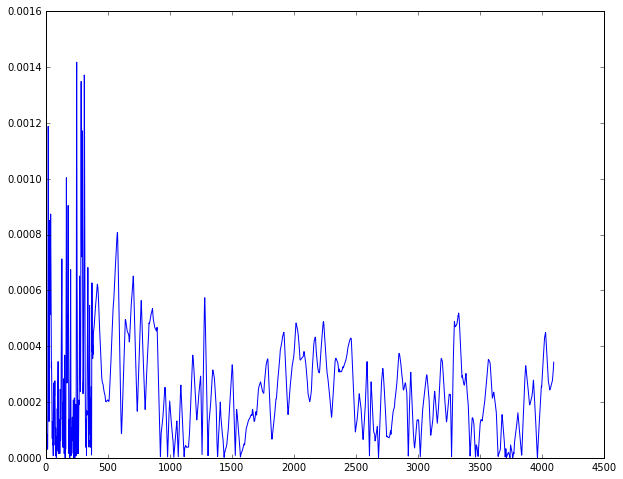

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.79419880e-26   1.00000000e+00   2.38606169e-30   7.55767354e-31
   0.00000000e+00   0.00000000e+00]


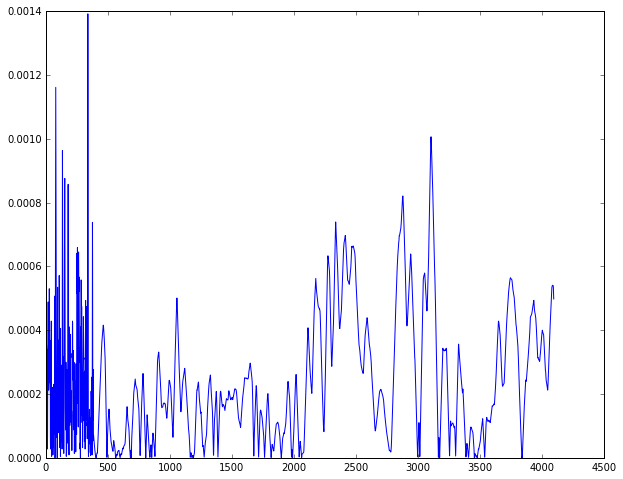

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.52984524e-31   1.00000000e+00   1.70455405e-35   3.05873617e-34
   0.00000000e+00   0.00000000e+00]


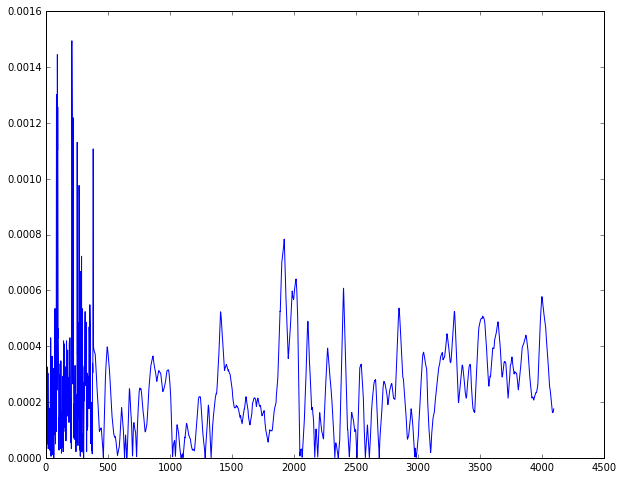

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.74666619e-29   1.00000000e+00   1.16865349e-32   2.21525308e-33
   0.00000000e+00   0.00000000e+00]


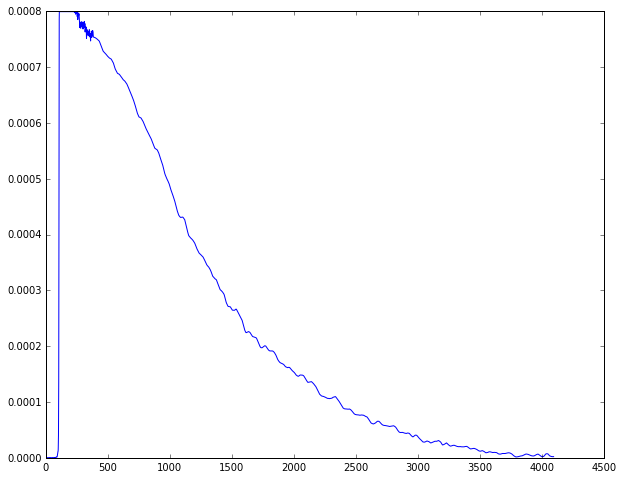

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.36159461e-19   1.00000000e+00   1.36377374e-25   7.29125925e-28
   1.47273486e-34   0.00000000e+00]


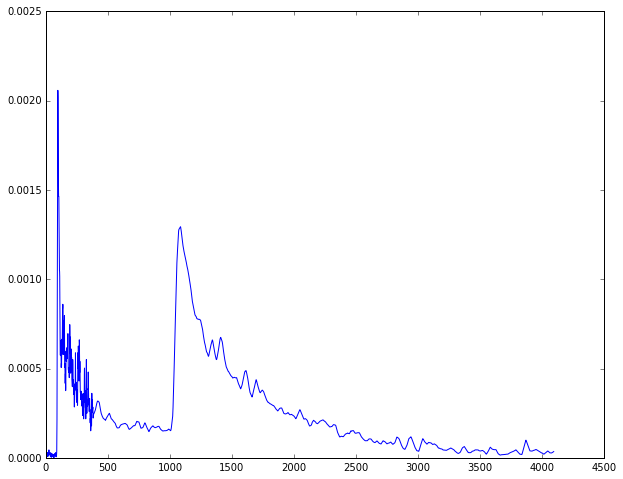

piled, flat, alpha, ls, 
 ls+beta, ref
[  6.65889194e-17   1.00000000e+00   1.45170113e-26   1.16084099e-27
   3.72727885e-36   0.00000000e+00]


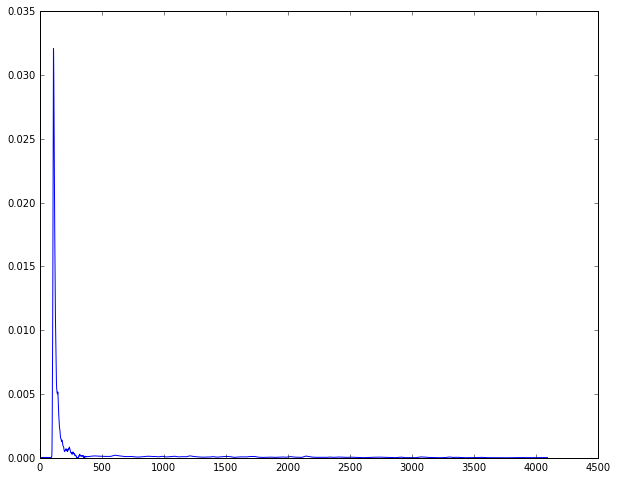

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.68504123e-14   1.00000000e+00   2.14622887e-18   3.40235461e-31
   0.00000000e+00   0.00000000e+00]


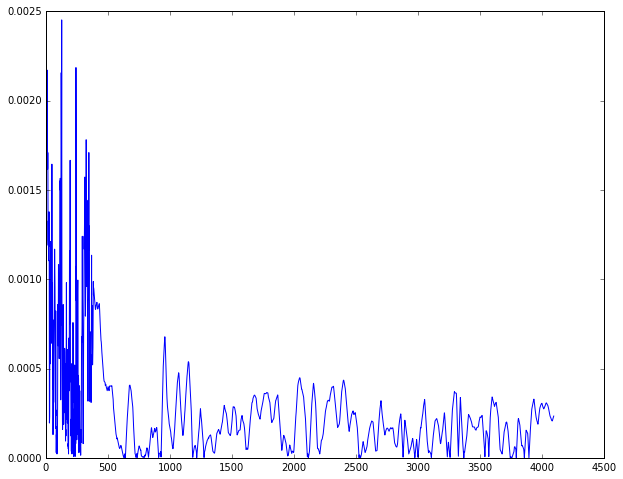

piled, flat, alpha, ls, 
 ls+beta, ref
[ 0.  1.  0.  0.  0.  0.]


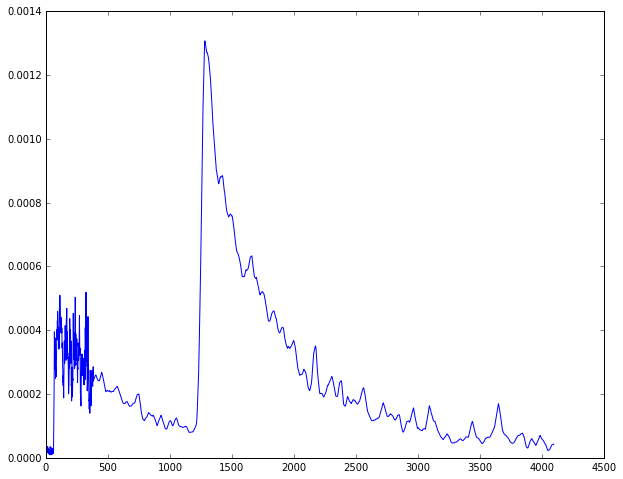

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.79067982e-20   1.00000000e+00   3.44589658e-27   4.28421768e-28
   2.36001979e-36   0.00000000e+00]


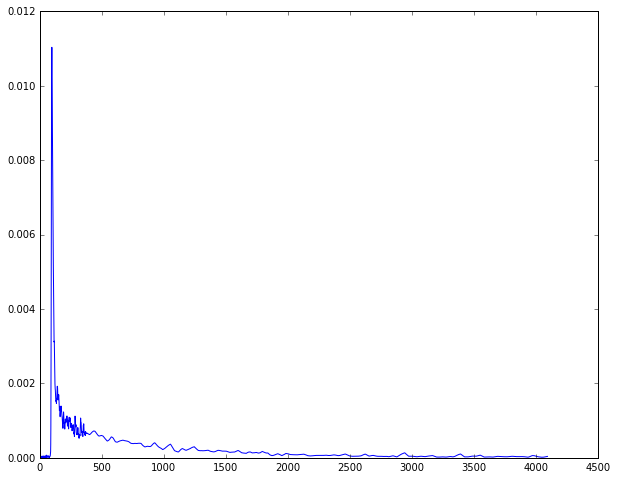

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.36394722e-03   9.96384382e-01   6.72405122e-06   1.17874576e-03
   6.62036982e-05   5.75743229e-12]


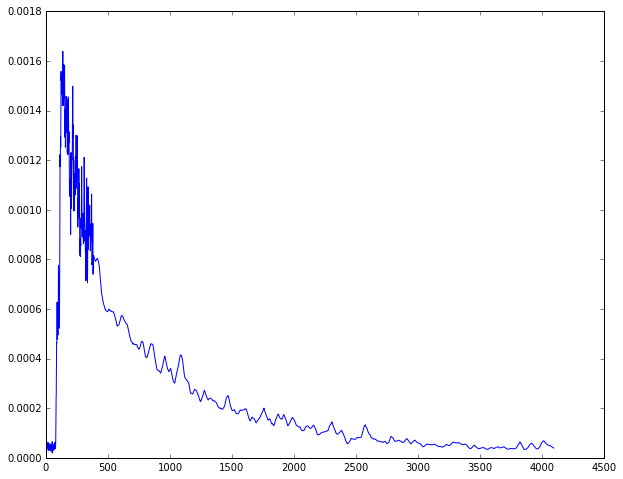

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.16017277e-19   1.00000000e+00   1.17043391e-24   3.36822855e-28
   9.77466715e-35   0.00000000e+00]


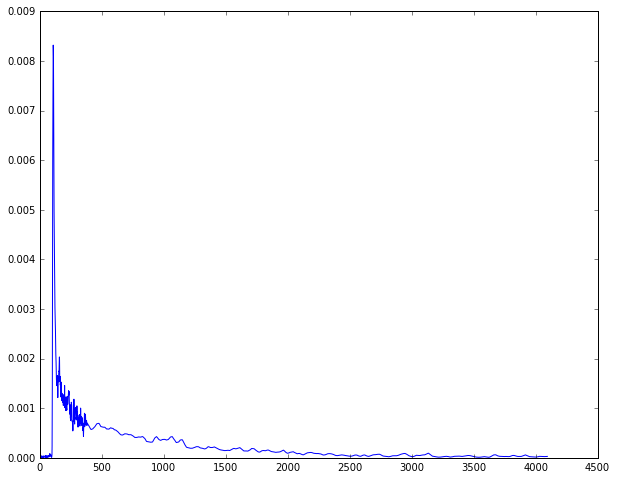

piled, flat, alpha, ls, 
 ls+beta, ref
[  8.49769322e-07   9.99999166e-01   1.73995378e-12   3.93929136e-16
   1.32860903e-16   9.32948085e-24]


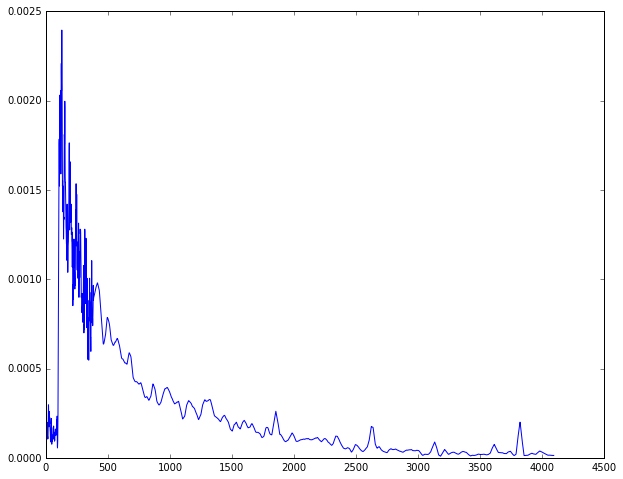

piled, flat, alpha, ls, 
 ls+beta, ref
[  7.72177848e-22   1.00000000e+00   8.92935386e-27   3.25663187e-32
   0.00000000e+00   0.00000000e+00]


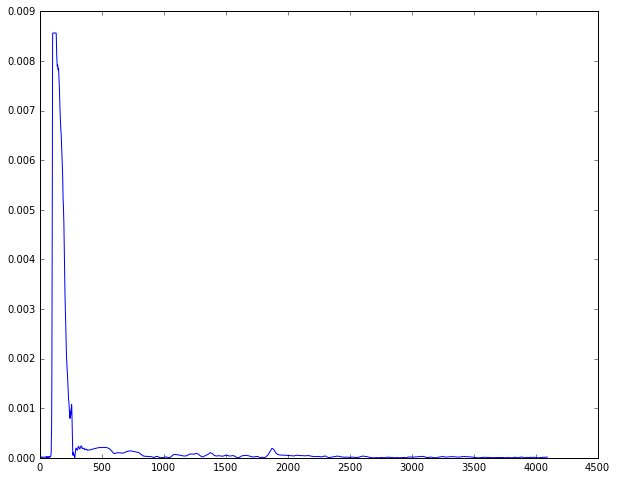

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.69623001e-20   1.00000000e+00   2.49232149e-17   1.35429268e-31
   1.42731610e-32   0.00000000e+00]


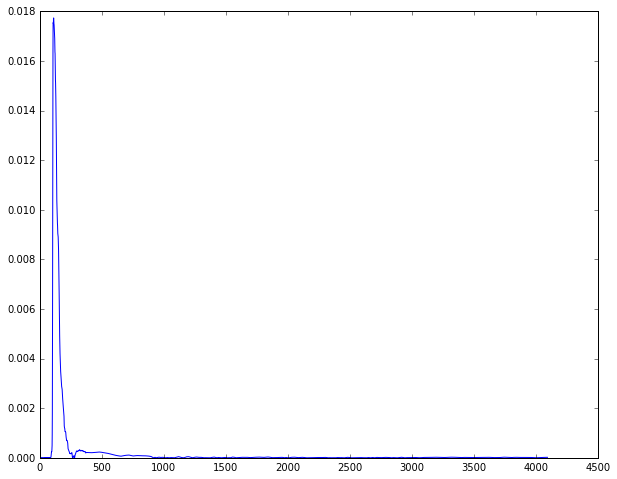

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.14865506e-17   1.00000000e+00   1.77135274e-14   5.97635735e-30
   1.80959211e-30   0.00000000e+00]


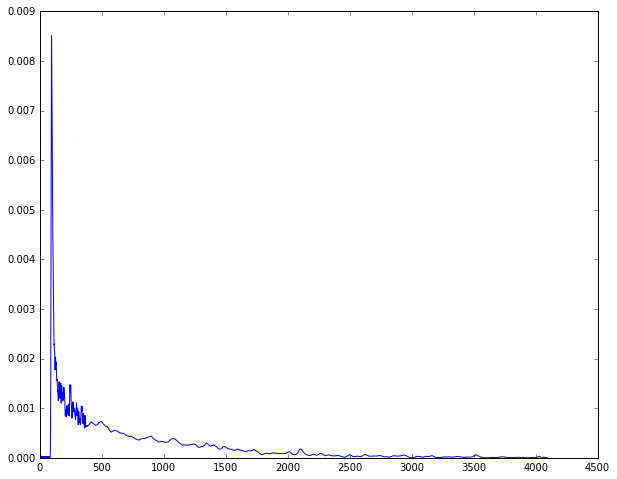

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.83111306e-03   9.68639195e-01   2.12207960e-04   2.20944826e-02
   6.22290932e-03   8.51513804e-10]


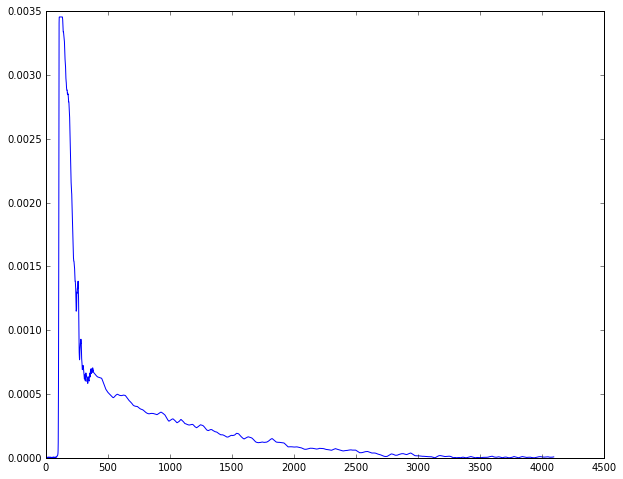

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.49563040e-14   1.00000000e+00   9.02774068e-15   1.83363647e-21
   5.85617835e-24   3.50385923e-36]


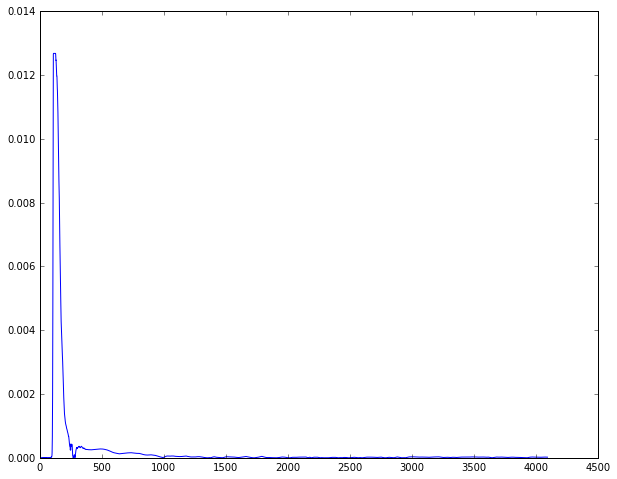

piled, flat, alpha, ls, 
 ls+beta, ref
[  4.82497969e-23   1.00000000e+00   5.00938721e-21   3.14786826e-36
   8.78406297e-38   0.00000000e+00]


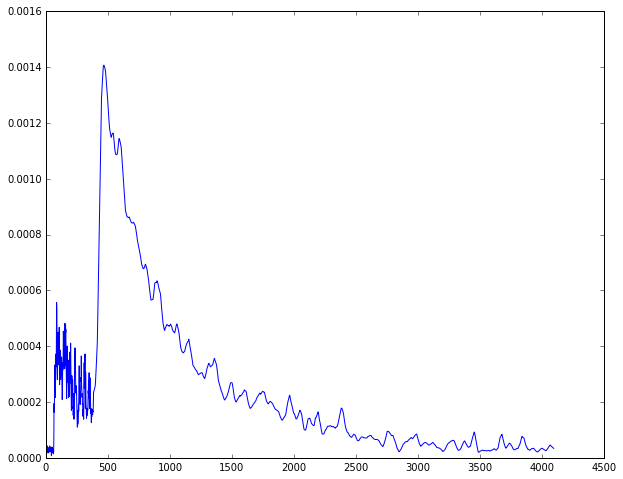

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.82019475e-19   1.00000000e+00   5.08007885e-25   2.50031493e-29
   3.76375756e-35   0.00000000e+00]


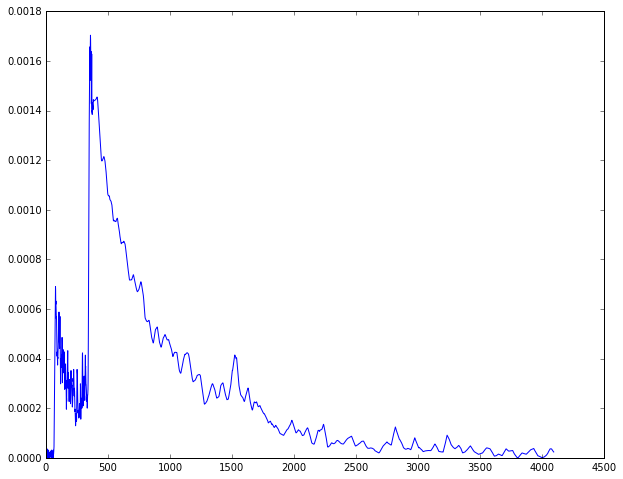

piled, flat, alpha, ls, 
 ls+beta, ref
[  3.08970038e-16   1.00000000e+00   2.31035180e-20   2.17981965e-25
   1.60671879e-29   0.00000000e+00]


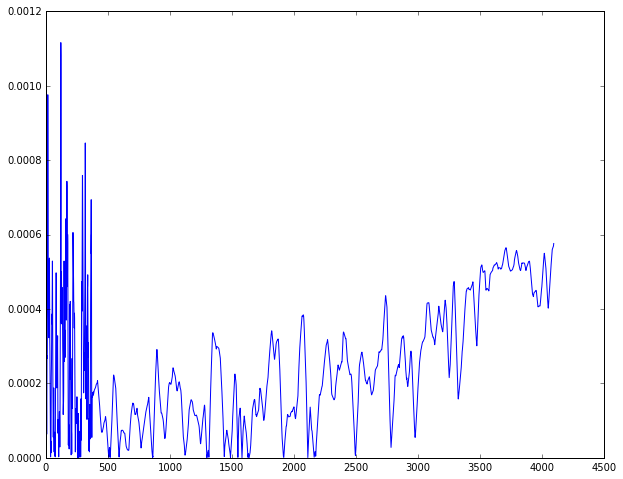

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.02957038e-28   1.00000000e+00   1.04446294e-30   6.60899833e-29
   2.51283895e-38   0.00000000e+00]


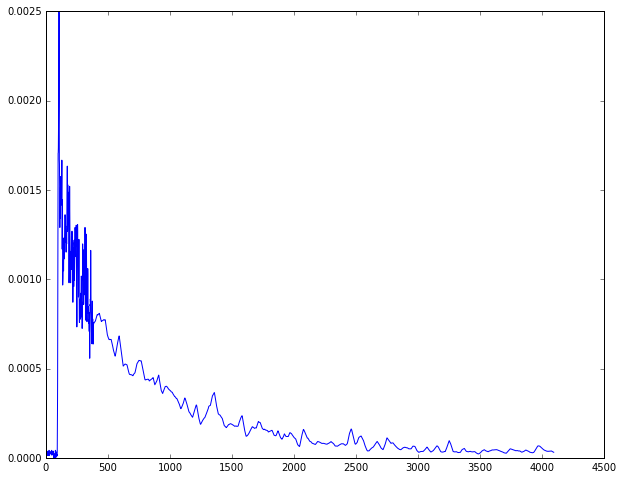

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.04476468e-17   1.00000000e+00   1.64138579e-22   6.35097370e-26
   1.13110510e-31   0.00000000e+00]


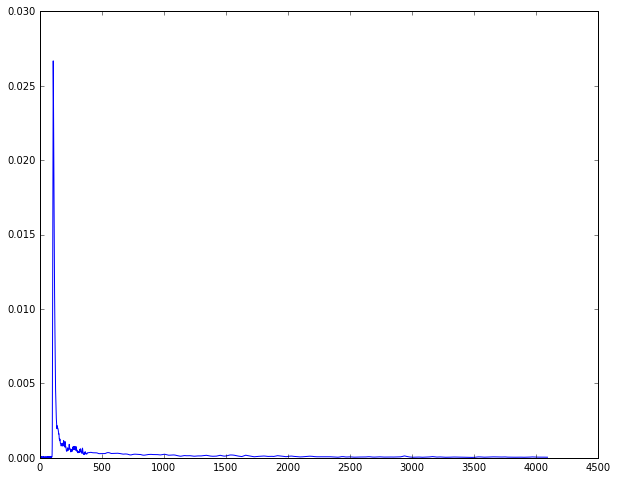

piled, flat, alpha, ls, 
 ls+beta, ref
[  5.05695880e-06   9.99994993e-01   8.40025112e-20   8.72833334e-24
   3.37729534e-28   2.09154374e-30]


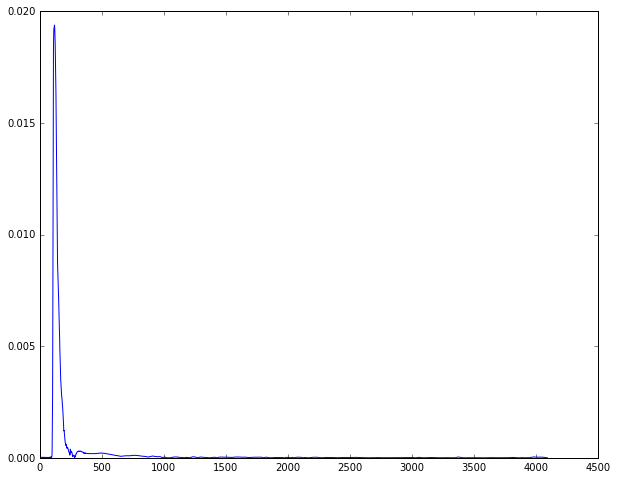

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.38007485e-19   1.00000000e+00   2.08950951e-18   1.01526970e-33
   2.58244088e-36   0.00000000e+00]


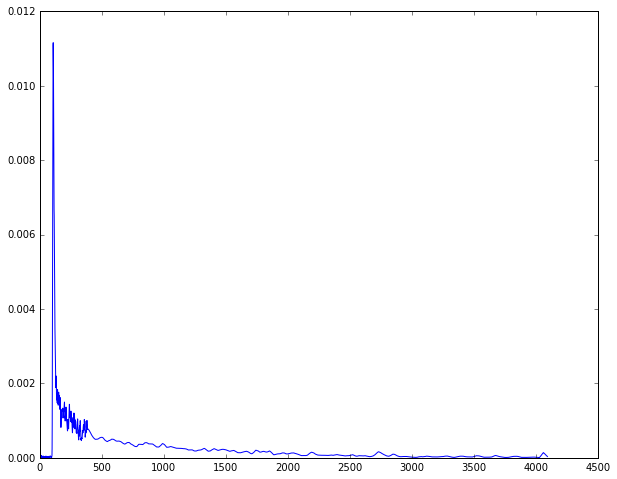

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.45589816e-04   9.99854445e-01   7.91398683e-11   1.45639048e-14
   5.07075003e-15   5.74410399e-19]


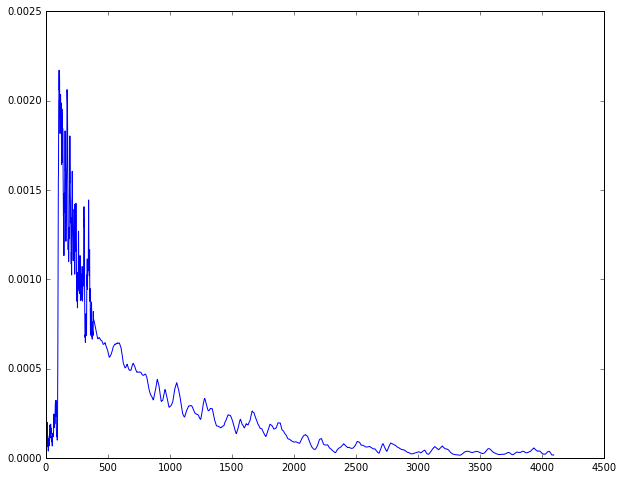

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.27070638e-18   1.00000000e+00   1.11084603e-22   1.93773474e-27
   3.85107672e-33   0.00000000e+00]


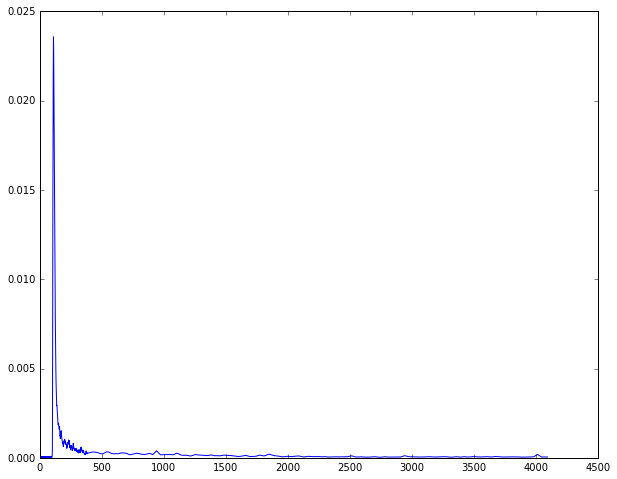

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.77806151e-07   9.99999762e-01   2.09816033e-17   6.22274860e-24
   4.65949169e-29   1.72876181e-29]


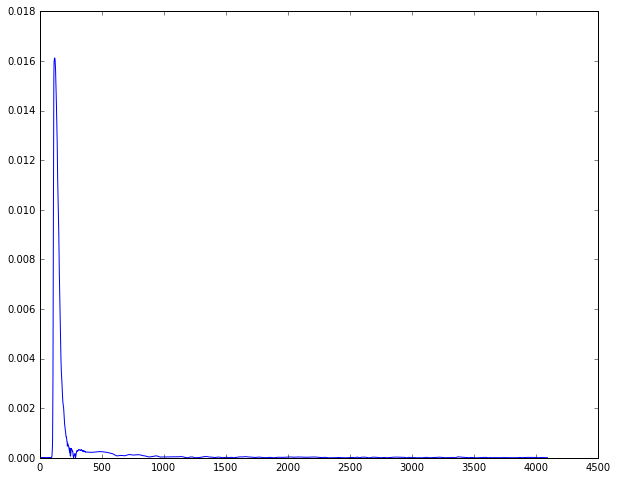

piled, flat, alpha, ls, 
 ls+beta, ref
[  2.39243980e-24   1.00000000e+00   8.92037916e-24   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


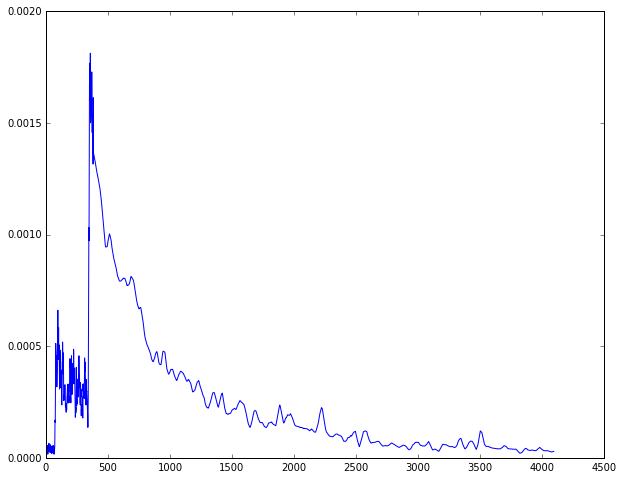

piled, flat, alpha, ls, 
 ls+beta, ref
[  8.45611179e-19   1.00000000e+00   5.17743485e-23   5.40720962e-29
   4.35982957e-34   0.00000000e+00]


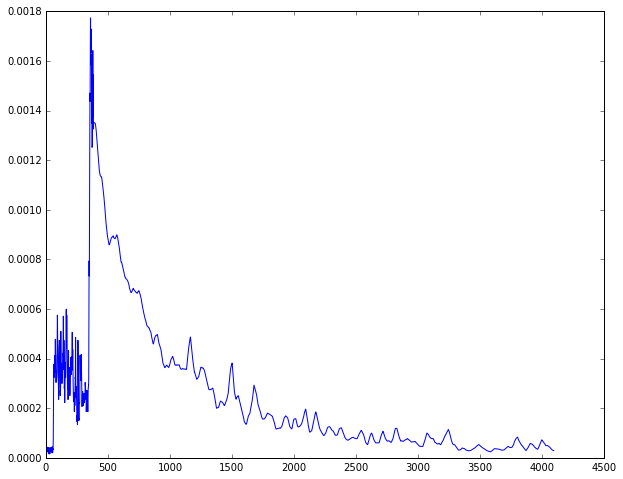

piled, flat, alpha, ls, 
 ls+beta, ref
[  1.76417320e-19   1.00000000e+00   9.63508004e-24   4.14430182e-29
   2.25433850e-34   0.00000000e+00]
CPU times: user 1min 10s, sys: 1min 20s, total: 2min 31s
Wall time: 3min 1s


In [16]:
%%time
dummy=0

PMTALL_test = NORM("TEST.root", "tree", "PMTALL")

for i in range(len(PMTALL_test)):
    k = np.random.randint(len(PMTALL_test))
    if test_out[k]==1:
        plt.figure()
        plt.plot(x,PMTALL_test[k])
        plt.show()
        print("piled, flat, alpha, ls, \n ls+beta, ref")
        print(predict_test_1[k])
        print("alpha, Ref")
        print(predict_test_2[k])
        dummy += 1
    if dummy==50:
        break
    

# Features extractor

To see what the CNN has learned?

Can be useful as a MC generator to create more data. predict_generator